In [2]:
import sys
import os
from dotenv import load_dotenv
from importlib import reload
from itertools import islice
import re
from collections import Counter

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Настройки окружения

In [6]:
# Проверяем, выполняется ли код на Kaggle
is_kaggle = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if is_kaggle:
    # Проверка, существует ли уже клонированный репозиторий
    if not os.path.exists('/kaggle/working/smf'):
        !git clone https://github.com/kogriv/smf.git
    else:
        print("Репозиторий уже клонирован.")
else:
    print("Запуск на локальной машине, клонирование не требуется.")

Запуск на локальной машине, клонирование не требуется.


In [7]:
try:
    # Путь для локальной машины (определяем корень проекта)
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    src_path = os.path.join(project_root, "src")

    # Проверяем, существует ли путь (т.е. файл "src" должен быть в корне проекта)
    if os.path.exists(src_path):
        sys.path.append(src_path)
        print("Local machine: Путь к 'src' добавлен.")
    else:
        raise FileNotFoundError(f"Path {src_path} not found on local machine.")

except:
    try:
        # Путь для Kaggle
        kaggle_src_path = '/kaggle/working/smf/src'
        if os.path.exists(kaggle_src_path):
            sys.path.append(kaggle_src_path)
            print("Kaggle: Путь к 'src' добавлен.")
        else:
            raise FileNotFoundError(f"Path {kaggle_src_path} not found on Kaggle.")

    except Exception as e:
        print(f"Не удалось добавить путь к 'src'. Ошибка: {e}")

Local machine: Путь к 'src' добавлен.


In [8]:
load_dotenv()

True

# Загрузка и просмотр данных

In [10]:
try:
    # Получаем путь для локальной машины из .env
    file_path = os.getenv('LOCAL_TRAIN_PATH') 
    dtr = pd.read_csv(file_path, lineterminator='\n')
    print('Train data loaded from local machine')

except Exception as e:
    if is_kaggle:
        try:
            # Получаем путь для Kaggle из .env
            file_path = os.getenv('KAGGLE_TRAIN_PATH')
            dtr = pd.read_csv(file_path, lineterminator='\n')
            print('Train data loaded from Kaggle')
    
        except Exception as e:
            print(f'Train data was not loaded from Kaggle. Error: {e}')
    else:
        print(f'Train data was not loaded from local machine.')

Train data loaded from local machine


In [11]:
try:
    # Получаем путь для локальной машины из .env
    file_path = os.getenv('LOCAL_TEST_PATH') 
    dts = pd.read_csv(file_path, lineterminator='\n')
    print('Test data loaded from local machine')

except Exception as e:
    if is_kaggle:
        try:
            # Получаем путь для Kaggle из .env
            file_path = os.getenv('KAGGLE_TEST_PATH')
            dts = pd.read_csv(file_path, lineterminator='\n')
            print('Test data loaded from Kaggle')
    
        except Exception as e:
            print(f'Test data was not loaded from Kaggle. Error: {e}')
    else:
        print(f'Test data was not loaded from local machine.')

Test data loaded from local machine


Уберем ограничение на отображение текста в ячейке и на количество строк.

In [13]:
pd.set_option('display.max_colwidth', None)

In [14]:
pd.set_option('display.max_rows', None)

In [15]:
dtr[:1]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzfajflyeT_Gg,Блогеры,0.0,0.0,NaN


In [16]:
pd.reset_option('display.max_rows')

Посмотрим уникальные значения категориальных полей.

In [18]:
print('broadcast:       ',dtr.broadcast.unique())
print('yt_channel_type: ',dtr.yt_channel_type.unique())
print('flag_closed:     ',dtr.flag_closed.unique())
print('international:   ',dtr.international.unique())
print('is_shorts:       ',dtr.is_shorts.unique())

broadcast:        ['none' nan 'live' 'upcoming']
yt_channel_type:  ['Блогеры' 'Мультфильмы' 'Детские' 'Shorts' nan]
flag_closed:      [ 0.  1. nan]
international:    [ 0.  1. nan]
is_shorts:        [ 0. nan  1.]


In [19]:
print('broadcast:       ',dts.broadcast.unique())
print('yt_channel_type: ',dts.yt_channel_type.unique())
print('flag_closed:     ',dts.flag_closed.unique())
print('international:   ',dts.international.unique())
print('is_shorts:       ',dts.is_shorts.unique())

broadcast:        ['none' 'live' nan 'upcoming']
yt_channel_type:  ['Детские' 'Блогеры' 'Мультфильмы' nan 'Shorts']
flag_closed:      [ 0.  1. nan]
international:    [ 0.  1. nan]
is_shorts:        [ 0. nan  1.]


In [20]:
pivot_shorts_seconds = dtr.pivot_table(
    values='seconds',
    index='is_shorts',
    aggfunc=['min', 'mean', 'max']
)
pivot_shorts_seconds.columns = ['min_seconds', 'mean_seconds', 'max_seconds']
pivot_shorts_seconds = pivot_shorts_seconds.reset_index()
pivot_shorts_seconds

,is_shorts,min_seconds,mean_seconds,max_seconds
0,0.0,0.0,2023.129919,504055.0
1,1.0,1.0,27.140457,60.0


Скопирую исходный датафрейм.

In [22]:
dtr_base = dtr.copy(deep=True)

## Пропуски

In [24]:
import promiss

In [25]:
# reload(promiss)

Использую созданный класс обработчик пропусков (обработка в соответствии с указаниями для каждого поля - см. словарь .missval_dict)

In [27]:
promiss.missval_dict

{'date': 'agg_mode',
 'reel_name': 'value_NA',
 'yt_reel_id': 'drop',
 'cartoon': 'value_none',
 'url': 'value_NA',
 'text': 'value_NA',
 'seconds': 'agg_median_by_yt_channel_type',
 'is_shorts': 'agg_mode',
 'broadcast': 'agg_mode_by_yt_channel_type',
 'yt_channel_id': 'value_NA',
 'yt_channel_name': 'value_NA',
 'yt_ch_url': 'value_NA',
 'yt_channel_type': 'agg_mode',
 'flag_closed': 'agg_mode',
 'international': 'agg_mode',
 'language': 'value_NA'}

In [28]:
missval_handler = promiss.MissingValueHandler(fill_strategy = 'custom_basic', fill_values = promiss.missval_dict)

# Подгоняем обработчик на тренировочных данных
missval_handler.fit(dtr_base)

# dtr = missval_handler.transform(dtr)

MissingValueHandler(fill_strategy='custom_basic',
                    fill_values={'broadcast': 'agg_mode_by_yt_channel_type',
                                 'cartoon': 'value_none', 'date': 'agg_mode',
                                 'flag_closed': 'agg_mode',
                                 'international': 'agg_mode',
                                 'is_shorts': 'agg_mode',
                                 'language': 'value_NA',
                                 'reel_name': 'value_NA',
                                 'seconds': 'agg_median_by_yt_channel_type',
                                 'text': 'value_NA', 'url': 'value_NA',
                                 'yt_ch_url': 'value_NA',
                                 'yt_channel_id': 'value_NA',
                                 'yt_channel_name': 'value_NA',
                                 'yt_channel_type': 'agg_mode',
                                 'yt_reel_id': 'drop'})

In [29]:
# Применяем обработчик к тестовым данным, исключая 'cartoon'
# dts.loc[:, dts.columns != 'cartoon'] = missval_handler.transform(dts.drop(columns=['cartoon']))
dts = missval_handler.transform(dts)

In [30]:
dtr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


Заменю пропуски значением "-1" для проверки значимости пропусков в категориальных полях на расщепление данных.

In [32]:
dtr = dtr.fillna(-1)

Создам ф-ю для формирования тестовых (маленькие) дф с условием вхождения строк для всех уникальных значений в категориальных полях

In [34]:
fields = ['is_shorts','broadcast','yt_channel_type','flag_closed','international']

In [35]:
def df_sample(df,fields,n):
    sample_df = pd.DataFrame()
    for field in fields:
        if 'cartoon' in df.columns:
            sample_df = pd.concat([sample_df,df[df.cartoon=='none'].groupby(field).sample(n=n,random_state=42)])
        else:
            sample_df = pd.concat([sample_df,df.groupby(field).sample(n=n,random_state=42)])
    sample_df = sample_df.drop_duplicates()
    return sample_df

In [36]:
none_obj_count = 2
rare_obj_count = 2
sample_dtr_none = df_sample(dtr,fields,none_obj_count)
sample_dtr_rare = dtr[dtr.cartoon !='none'].groupby('cartoon').sample(n=rare_obj_count,random_state=42)
sample_dtr = pd.concat([sample_dtr_none,sample_dtr_rare])
# sample_dtr.reset_index(inplace=True)
sample_dtr.shape

(116, 16)

In [37]:
print('broadcast:       ',sample_dtr.broadcast.unique())
print('yt_channel_type: ',sample_dtr.yt_channel_type.unique())
print('flag_closed:     ',sample_dtr.flag_closed.unique())
print('international:   ',sample_dtr.international.unique())
print('is_shorts:       ',sample_dtr.is_shorts.unique())

broadcast:        [-1 'none' 'live' 'upcoming']
yt_channel_type:  ['Блогеры' 'Мультфильмы' 'Детские' -1 'Shorts']
flag_closed:      [ 0.  1. -1.]
international:    [ 0. -1.  1.]
is_shorts:        [-1.  0.  1.]


In [38]:
sample_dts = df_sample(dts,fields,5)
# sample_dts.reset_index(inplace=True)
sample_dts.shape

(65, 15)

In [39]:
print('broadcast:       ',sample_dts.broadcast.unique())
print('yt_channel_type: ',sample_dts.yt_channel_type.unique())
print('flag_closed:     ',sample_dts.flag_closed.unique())
print('international:   ',sample_dts.international.unique())
print('is_shorts:       ',sample_dts.is_shorts.unique())

broadcast:        ['none' 'live' 'upcoming']
yt_channel_type:  ['Блогеры' 'Мультфильмы' 'Детские' 'Shorts']
flag_closed:      [0. 1.]
international:    [0. 1.]
is_shorts:        [0. 1.]


In [40]:
print(dtr.columns)

Index(['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds',
       'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name',
       'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international',
       'language'],
      dtype='object')


In [41]:
# # Преобразование столбца 'date' в тип datetime
# dtr['d'] = pd.to_datetime(sample_dtr['date'])

# # Извлечение дня недели
# dtr['dow'] = sample_dtr['d'].dt.dayofweek

# Поработаем деревом

Посмотрим как разные комбинации значений признаков расщепляют датасет на классы.

In [44]:
dtr[dtr.cartoon!='none'].groupby(['flag_closed', 'broadcast', 'international']).size().reset_index().drop(columns=0)

,flag_closed,broadcast,international
0,-1.0,-1,-1.0
1,0.0,-1,0.0
2,0.0,live,0.0
3,0.0,none,0.0
4,0.0,none,1.0
5,0.0,upcoming,0.0
6,1.0,-1,0.0
7,1.0,none,0.0


In [45]:
dtr[dtr.cartoon=='none'].groupby(['flag_closed', 'broadcast', 'international']).size().reset_index().drop(columns=0)

,flag_closed,broadcast,international
0,-1.0,-1,-1.0
1,-1.0,none,-1.0
2,0.0,-1,0.0
3,0.0,live,0.0
4,0.0,none,0.0
5,0.0,upcoming,0.0
6,1.0,-1,0.0
7,1.0,none,0.0
8,1.0,upcoming,0.0


In [46]:
# Общее количество образцов в каждом классе
total_not_none = len(dtr[dtr.cartoon != 'none'])
total_none = len(dtr[dtr.cartoon == 'none'])

# Уникальные тройки для случаев, когда cartoon != 'none', с подсчетом
set1 = dtr[dtr.cartoon != 'none'].groupby(['flag_closed', 'broadcast', 'international']).size().reset_index(name='count')
set1['set'] = 'cartoon_not_none'
set1['fraction'] = set1['count'] / total_not_none

# Уникальные тройки для случаев, когда cartoon == 'none', с подсчетом
set2 = dtr[dtr.cartoon == 'none'].groupby(['flag_closed', 'broadcast', 'international']).size().reset_index(name='count')
set2['set'] = 'cartoon_none'
set2['fraction'] = set2['count'] / total_none

# Найти тройки, которые есть в set1, но отсутствуют в set2
diff1 = set1.merge(set2, on=['flag_closed', 'broadcast', 'international'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')

# Найти тройки, которые есть в set2, но отсутствуют в set1
diff2 = set2.merge(set1, on=['flag_closed', 'broadcast', 'international'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')

# Объединить оба результата, чтобы получить все несовпадающие тройки
non_matching_triples = pd.concat([diff1, diff2], ignore_index=True)

non_matching_triples.drop(['count_y','set_y','fraction_y'],axis=1)

,flag_closed,broadcast,international,count_x,set_x,fraction_x
0,0.0,none,1.0,497,cartoon_not_none,0.095946
1,-1.0,none,-1.0,3,cartoon_none,0.000038
2,1.0,upcoming,0.0,1,cartoon_none,0.000013


Видим, что для некоторых значений троек (flag_closed, broadcast, international) есть разделение для классов none/not_none. Тотального расщепления нет

Функция для отображения того как комбинации уникальных значений выбранных комбинаций полей расщепляют датасет.

In [49]:
def field_frac_intersect(fields):
    # fields - список полей по комбинациям которых смотрим вхождение в классы

    # Выбрать комбинации полей, где dtr.cartoon != 'none'
    fields_values_with_cartoon = dtr[dtr.cartoon != 'none'].groupby(fields).size().reset_index()[fields].astype(str).agg('_'.join, axis=1).unique()

    # Выбрать комбинации полей, где dtr.cartoon == 'none'
    fields_values_without_cartoon = dtr[dtr.cartoon == 'none'].groupby(fields).size().reset_index()[fields].astype(str).agg('_'.join, axis=1).unique()

    # Найти пересечение комбинаций, где есть и записи с cartoon != 'none', и cartoon == 'none'
    common_fields_values = np.intersect1d(fields_values_with_cartoon, fields_values_without_cartoon)

    # Общее количество уникальных комбинаций полей с dtr.cartoon != 'none'
    total_fields_values_with_cartoon = len(fields_values_with_cartoon)

    # Доля комбинаций, которые попали в обе категории (cartoon != 'none' и cartoon == 'none')
    fraction_common_fields_values = len(common_fields_values) / total_fields_values_with_cartoon if total_fields_values_with_cartoon > 0 else 0

    # Количество записей с dtr.cartoon != 'none' для общих комбинаций полей
    total_cartoon_objects = len(dtr[dtr.cartoon != 'none'])
    total_objects_with_common_fields_values = len(dtr[(dtr.cartoon != 'none') & (dtr[fields].astype(str).agg('_'.join, axis=1).isin(common_fields_values))])

    # Доля объектов с общими комбинациями полей в общем количестве объектов с dtr.cartoon != 'none'
    fraction_of_objects_with_common_fields_values_in_total_cartoon_objects = total_objects_with_common_fields_values / total_cartoon_objects if total_cartoon_objects > 0 else 0

    # Результаты
    print(f'Исходный размер множества уникальных значений комбинаций на размеченных данных: {len(fields_values_with_cartoon)}')
    if len(fields_values_with_cartoon) < 10:
        print(f'Множество уникальных значений комбинаций на размеченных данных {fields_values_with_cartoon}')
    print(f'Размер уникальных комбинаций общих на размеченных и не размеченных данных: {len(common_fields_values)}')
    if len(fields_values_with_cartoon) < 10:
        print(f'Множество уникальных значений комбинаций на размеченных данных {common_fields_values}')
    print(f"Доля объектов с общими комбинациями полей в размеченных данных для комбинации полей {fields} составляет: {fraction_of_objects_with_common_fields_values_in_total_cartoon_objects:.4f}")
    print(f"Доля в комбинациях на размеченных данных для комбинации полей {fields} составляет: {fraction_common_fields_values:.4f}")


In [50]:
fields = ['yt_channel_id']
field_frac_intersect(fields)

Исходный размер множества уникальных значений комбинаций на размеченных данных: 105
Размер уникальных комбинаций общих на размеченных и не размеченных данных: 95
Доля объектов с общими комбинациями полей в размеченных данных для комбинации полей ['yt_channel_id'] составляет: 0.8736
Доля в комбинациях на размеченных данных для комбинации полей ['yt_channel_id'] составляет: 0.9048


Видим, что есть 10 каналов, корторые попадают только в размеченные классы

In [52]:
fields = ['language']
field_frac_intersect(fields)

Исходный размер множества уникальных значений комбинаций на размеченных данных: 4
Множество уникальных значений комбинаций на размеченных данных ['-1' 'arabic' 'english' 'spanish']
Размер уникальных комбинаций общих на размеченных и не размеченных данных: 1
Множество уникальных значений комбинаций на размеченных данных ['-1']
Доля объектов с общими комбинациями полей в размеченных данных для комбинации полей ['language'] составляет: 0.9041
Доля в комбинациях на размеченных данных для комбинации полей ['language'] составляет: 0.2500


Опознанные языки относятся только к отмеченным классам.

In [54]:
fields = ['yt_channel_type']
field_frac_intersect(fields)

Исходный размер множества уникальных значений комбинаций на размеченных данных: 5
Множество уникальных значений комбинаций на размеченных данных ['-1' 'Shorts' 'Блогеры' 'Детские' 'Мультфильмы']
Размер уникальных комбинаций общих на размеченных и не размеченных данных: 5
Множество уникальных значений комбинаций на размеченных данных ['-1' 'Shorts' 'Блогеры' 'Детские' 'Мультфильмы']
Доля объектов с общими комбинациями полей в размеченных данных для комбинации полей ['yt_channel_type'] составляет: 1.0000
Доля в комбинациях на размеченных данных для комбинации полей ['yt_channel_type'] составляет: 1.0000


In [55]:
fields = ['broadcast','flag_closed','international']
field_frac_intersect(fields)

Исходный размер множества уникальных значений комбинаций на размеченных данных: 8
Множество уникальных значений комбинаций на размеченных данных ['-1_-1.0_-1.0' '-1_0.0_0.0' '-1_1.0_0.0' 'live_0.0_0.0' 'none_0.0_0.0'
 'none_0.0_1.0' 'none_1.0_0.0' 'upcoming_0.0_0.0']
Размер уникальных комбинаций общих на размеченных и не размеченных данных: 7
Множество уникальных значений комбинаций на размеченных данных ['-1_-1.0_-1.0' '-1_0.0_0.0' '-1_1.0_0.0' 'live_0.0_0.0' 'none_0.0_0.0'
 'none_1.0_0.0' 'upcoming_0.0_0.0']
Доля объектов с общими комбинациями полей в размеченных данных для комбинации полей ['broadcast', 'flag_closed', 'international'] составляет: 0.9041
Доля в комбинациях на размеченных данных для комбинации полей ['broadcast', 'flag_closed', 'international'] составляет: 0.8750


In [56]:
fields =  ['is_shorts','broadcast','yt_channel_type','flag_closed','international']
field_frac_intersect(fields)

Исходный размер множества уникальных значений комбинаций на размеченных данных: 16
Размер уникальных комбинаций общих на размеченных и не размеченных данных: 15
Доля объектов с общими комбинациями полей в размеченных данных для комбинации полей ['is_shorts', 'broadcast', 'yt_channel_type', 'flag_closed', 'international'] составляет: 0.9041
Доля в комбинациях на размеченных данных для комбинации полей ['is_shorts', 'broadcast', 'yt_channel_type', 'flag_closed', 'international'] составляет: 0.9375


In [57]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(sample_dtr
        [['cartoon','text']][:5]
       )
pd.reset_option('display.max_rows')

,cartoon,text
37205,none,[Супер Сеня играет с Животными] Супер Сеня играет с ЖивотнымиSubscribe: https://bit.ly/2Q9Lgme
27924,none,"[Капитан Пронин внук майора Пронина. Рисованный мультик Золотая коллекция] БЕСПЛАТНО СМОТРИМ ВСЁ ТУТ https://smotrim.ru/brands/tag/231140/utmsourceyoutubeutmmediumallutmcampaignall0 Капитан Пронин внук майора Пронина. Рисованный мультик на канале ""Золотая коллекция"".Подписаться на лучшие советские мультики https://www.youtube.com/channel/UCU06hfFzcBjQl9Ih2SvpoQsubconfirmation1Все мультфильмы подряд https://www.youtube.com/playlistlistPLYymTuJXocGKmjzy9GLsS4GIl89EXdkРисованный мультипликационный фильм.Пародия на современные западные и отечественные боевики.Смотрите популярные советские мультфильмы:Мама для мамонтёнка https://www.youtube.com/watchvsVYMsNay8G0По дороге с облаками https://www.youtube.com/watchv0DnjD7w2FIПодарок для слона https://www.youtube.com/watchv5FZ1yKwQCOYДом для Кузьки https://www.youtube.com/watchv8JFdlT5XGNcПадал прошлогодний снег https://www.youtube.com/watchvDwJznO6SqyMКлад. Тигрёнок и его друзья https://www.youtube.com/watchvIz1kKv34wYЛето кота Леопольда https://www.youtube.com/watchvXW8XHW3hs3oТрям Здравствуйте https://www.youtube.com/watchvV4pG9UISMu8Чертенок с пушистыми хвостом https://www.youtube.com/watchvcXSJHRmqV2IНу, погоди https://www.youtube.com/watchvzbDFapTqA"
76846,none,"[КТО ПОИМЕТ МЕНЯ ЧЕРЕЗ 10000 ЛЕТ ТОПЛЕС] Смотрите новый сериал Пенниуорт на КиноПоиске: https://ya.cc/6NfybСериал доступен по подписке. Первые 30 дней подписки бесплатно.Ищите символы в выпуске, расшифровывайте их с помощью словаря https://bit.ly/2LUjoia и вводите слова без пробелов здесь: https://ya.cc/6NfzYПромокод на 2 месяца подписки для новых пользователей действует до 10 сентября. УдачиP.S. При расшифровке у вас получится фраза из набора слов. Вводить ее нужно целиком без пробелов.Что общего у иероглифов и эмоджи Можно ли сделать универсальный язык целиком из символов, без букв Как такой язык сможет изменить наше мышление Каким должно быть идеальное послание инопланетянамОТДЫХАЕМ ОТ НАУКИ ТУТ https://goo.gl/LFf4DjЗДЕСЬ ИЩИ ДОПОЛНИТЕЛЬНУЮ ИНФОРМАЦИЮTELEGRAM https://telega.at/toplesofficialВК https://vk.com/toplesshowЯ В VK https://vk.com/yanlapotkovTWITTER https://twitter.com/drunishTELEGRAM https://t.me/toplesofficialСмотрите больше видео:КОСМОС https://goo.gl/uCkfD3ТЕХНОЛОГИИ https://goo.gl/vLdH2HИГРЫ https://goo.gl/17LhoNКИНО https://goo.gl/ZUgWGDVLOG https://goo.gl/z88cuSСТРАХ https://goo.gl/b6fu5KЖИВОТНЫЕ https://goo.gl/jn93tzОЧЕНЬ ИНТЕРЕСНЫЕ https://goo.gl/PrcrtjРеклама, сотрудничество: toples.showgmail.comТОПЛЕС ЯНТОПЛЕС ЯНЛАПОТКОВ TOPLES ИСТОЧНИКИ: https://qps.ru/Zb1C5Над выпуском работали:Ян ЛапотковВадим КуликовМихаил МартыновАндрей СавельевКатя АдаричеваСекретный дизайнер уровень богАлексин Андрей"
13127,none,"[Лев и его активные истории с папой. Прикольная детская история в веселом сборнике.] Веселый активный сборник для детей от Левы и его семьи. Здесь вы увидите приколы и то как нужно заниматься спортом и правильно питаться. Чумовая история про супер героя и лаву, а так же как папа хотел покормить своего сына и ему постоянно что то прилипало к лицу.Друзья, приветствуем Вас на нашем канале Лев и Семья, известном как LEV Family SHOWМы любим радовать Вас веселыми и познавательными историями. Лёва и папа часто разыгрывают какиенибудь образовательные, весёлые истории для детей. Для Вас мы стараемся снимать все самое интересное и самое лучшееподписывайтесь на инстаграм Левыhttps://www.instagram.com/lev.family.show/hlruЛевиСемья LevFamilyShow ДетскиеИстории"
76299,none,"[Фермер в Делле shorts farmerinthedell kidstv nurseryrhymes kidssong] shorts Фермер в Делле это традиционная детская стишка и песенная игра, которая нравится детям на протяжении многих поколений. Песня обычно имеет повторяющуюся и запоминающуюся мелодию, поэтому маленьким детям легко ее подпевать. Тексты песен вращаются вокруг темы фермера и его различных взаимодействий внутри сообщества. Структура часто включает 

In [58]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
pd.set_option('display.max_rows', None)
display(sample_dts[['date','reel_name','yt_channel_type','seconds']][:5])
pd.reset_option('display.max_rows')

,date,reel_name,yt_channel_type,seconds
27891,2017-09-25,ЗЛЫЕ ЗМЕИ как Слизерио и WORMAXIO мультик игра про выращивание змеи Angry Snakes для детей от FFGTV,Блогеры,511.0
35173,2020-12-29,Челлендж по цветам Собери блок эмоций своего ЦВЕТА My little Nastya,Блогеры,657.0
45351,2023-06-17,Репетиция оркестра Короткометражный мультфильм 0,Мультфильмы,391.0
12551,2024-07-24,Wyścigi z Batwheels Batwheels po Polsku DCKidsInternational,Мультфильмы,1809.0
3022,2016-10-05,Мультики для самых маленьких Считаем с Полой: Сладкая Форма,Детские,329.0


Однозначных расщеплений на классы для разных комбинаций значений полей не найдено.

# Словарь классификации

Создам словарь для простой классификации. Идея понять и повтороить ход ручной классификации заказчика. Предполагаем, что используются простые правила фильтрации датасета.

In [62]:
d = {}

In [63]:
ds = """
{ tardet_i: {
         'order' : 0 (define target only) / 1 (first in similar) / 2 (next in similar or misdefine none),
         'mth' : 'type_method',
         'pattern' : 'search_pattern_type',
         'stop_pattern': 'stop_pattern_type'
         'methods': {
                    'reel_name': {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'text'     : {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'yt_channel_name' : {'any_word_list':[]}
                    'is_shorts' : None # value_for_filter (0/1, default=None)
                },
         'comment':'some_text'
        }
    }
"""

tardet_i : ключ класса,  
'order' : порядок классификации, 0 - однозначное определение таргета, 1 - определение такргета и "нахлест" на другой класс, 2 - второй элемент в паре "нахлеста"  
'mth' : ключ метода отбора,  
'pattern' : ключ паттерна поиска (способ формирования строки для поиска),  
'stop_pattern': ключ паттерна стоп слов,  
'methods' : словарь с данными по каждому рассмтриваемому полю

In [65]:
print(ds)


{ tardet_i: {
         'order' : 0 (define target only) / 1 (first in similar) / 2 (next in similar or misdefine none),
         'mth' : 'type_method',
         'pattern' : 'search_pattern_type',
         'stop_pattern': 'stop_pattern_type'
         'methods': {
                    'reel_name': {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'text'     : {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'yt_channel_name' : {'any_word_list':[]}
                    'is_shorts' : None # value_for_filter (0/1, default=None)
                },
         'comment':'some_text'
        }
    }



Создам словарь в который помещу ключи методов отбора со значением инструкции отбора, ключи паттернов поиска и стоп-слов

In [67]:
meth = {}

In [68]:
dtr.cartoon.value_counts(normalize=True)[:5]

cartoon
none               0.937898
Маша и медведь     0.010226
Говорящий Том      0.007061
Буба               0.006342
Кошечки собачки    0.005239
Name: proportion, dtype: float64

In [69]:
pd.set_option('max_colwidth',None)

# По-полям, по-полям. Пройдем класси-фи-ка-то-ром

## Маша и медведь

In [72]:
target = 'Маша и медведь'

In [73]:
# dtr[dtr.cartoon == target][['text']][:1]

In [74]:
word_list = ['masha and the bear', 'mashaandthebear', 'маша и медведь',
             'машкины страшилки', 'машины сказки', 'masha and friends']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url']].head(10)

,text,url


In [75]:
dtr[(dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url','is_shorts']]['is_shorts'].unique()

array([1.])

видим, что при наличии нужных слов в разметку не попадают шортсы

In [77]:
ddd = \
dtr[
        (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
     &  (dtr.is_shorts.fillna('').astype(int) == 0)
   ][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Маша и медведь    846
Name: count, dtype: int64

(846,)

(853, 16)

In [78]:
meth['Маша и медведь']=\
 """
 (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
 &  (dtr.is_shorts.fillna('').astype(int) == 0)
 """
    

In [79]:
meth['pattern']=\
"""
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))
"""

In [80]:
print(ds)


{ tardet_i: {
         'order' : 0 (define target only) / 1 (first in similar) / 2 (next in similar or misdefine none),
         'mth' : 'type_method',
         'pattern' : 'search_pattern_type',
         'stop_pattern': 'stop_pattern_type'
         'methods': {
                    'reel_name': {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'text'     : {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'yt_channel_name' : {'any_word_list':[]}
                    'is_shorts' : None # value_for_filter (0/1, default=None)
                },
         'comment':'some_text'
        }
    }



In [81]:
d['Маша и медведь'] = {

'order':0,
'meth' : 'Маша и медведь',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['masha and the bear', 'mashaandthebear',
                                     'маша и медведь','машкины страшилки',
                                     'машины сказки', 'masha and friends'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : 0 # value_for_filter (0/1, default=None)
  },
'comment': 'простая обработка по имени. плюс не шортсы'
}

## Говорящий Том

In [83]:
target = 'Говорящий Том'

In [84]:
# dtr[dtr.cartoon == target][['text']][:1]

In [85]:
word_list = ['Talking Tom']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url']].head(10)

,text,url


In [86]:
dtr[(dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url','is_shorts']]

,text,url,is_shorts


Говорящий Том имеет только одно слово для поиска

In [88]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Говорящий Том    589
Name: count, dtype: int64

(589,)

(589, 16)

In [89]:
meth['reel_name_only']=\
"""
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
"""

In [90]:
d['Говорящий Том'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Talking Tom'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'простая обработка по имени. плюс не шортсы'
}

## Буба

In [92]:
display(dtr.cartoon.value_counts(normalize=True)[2:5])
target = 'Буба'
# dtr[dtr.cartoon == target][['text']][:1]

cartoon
Говорящий Том      0.007061
Буба               0.006342
Кошечки собачки    0.005239
Name: proportion, dtype: float64

In [93]:
word_list = ['Booba']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url']].head(10)

,text,url


In [94]:
dtr[(dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url','is_shorts']]

,text,url,is_shorts


In [95]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Буба    529
Name: count, dtype: int64

(529,)

(529, 16)

In [96]:
d['Буба'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Booba'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'простая обработка по имени'
}

## Кошечки собачки

In [98]:
display(dtr.cartoon.value_counts(normalize=True)[3:6])
target = 'Кошечки собачки'
# dtr[dtr.cartoon == target][['text']][:1]

cartoon
Буба               0.006342
Кошечки собачки    0.005239
Енотки             0.004544
Name: proportion, dtype: float64

In [99]:
word_list = ['КОШЕЧКИСОБАЧКИ']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url']].head(10)

,text,url


In [100]:
dtr[(dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url','is_shorts']]

,text,url,is_shorts


In [101]:
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','text','url','is_shorts']]['cartoon'].unique()

array(['Кошечки собачки'], dtype=object)

In [102]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Кошечки собачки    437
Name: count, dtype: int64

(437,)

(437, 16)

In [103]:
d['Кошечки собачки'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['КОШЕЧКИСОБАЧКИ'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'простая обработка по имени'
}

## Енотки

In [105]:
dtr.cartoon.value_counts(normalize=True)[4:7]

cartoon
Кошечки собачки    0.005239
Енотки             0.004544
Бэтмен             0.004232
Name: proportion, dtype: float64

In [106]:
target = 'Енотки'
dtr[dtr.cartoon == target][['text']][:1]

,text
154,"[ألحان الراكون رسوم متحركة جديدة للأطفال] ااشتركوا بقناتنا وشاهدوا حلقات جديدةhttps://www.youtube.com/RockoonsArab/videos""ألحان الراكون"" هو مسلسل كرتوني تعليمي موسيقي موجه للأطفال بين سن الثانية والرابعة يساعد الأطفال على تطوير مهارات إبداعية واجتماعية وإظهار التعاطف وتقدير الصداقة وتوسيع آفاقهم منذ سن صغيرة. تجذب حلقاته القصيرة انتباه الأطفال في حين يساعدهم طابعه الموسيقي على استيعاب المعلومات المطروحة بشكل أفضل."


In [107]:
word_list = ['الراكون','Rockoons','MUSIPACHES','Енотки']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  & ~(dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['yt_channel_name','text','url','language']].head(10)

,yt_channel_name,text,url,language


In [108]:
dtr[(dtr.cartoon == 'none') 
  & ((dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))) 
][['text','url','is_shorts']]

,text,url,is_shorts


In [109]:
dtr[
#     (dtr.cartoon == 'none') & 
    ((dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))) 
][['cartoon','text','url','is_shorts']]['cartoon'].unique()

array(['Енотки'], dtype=object)

In [110]:
ddd = \
dtr[
#     (dtr.cartoon == 'none') & 
    (
        (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
      | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
    )
     # &  (dtr.is_shorts.fillna('').astype(int) == 0)
   ][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Енотки    379
Name: count, dtype: int64

(379,)

(379, 16)

In [111]:
meth['reel_name_or_channel_name']=\
"""
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
| (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
"""

In [112]:
d['Енотки'] = {

'order':0,
'meth': 'reel_name_or_channel_name',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['الراكون','Rockoons','MUSIPACHES','Енотки'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : {'any_word_list':['الراكون','Rockoons','MUSIPACHES','Енотки']},
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени. плюс имя канала'
}

## Бэтмен

In [114]:
display(dtr.cartoon.value_counts(normalize=True)[5:8])
target = 'Бэтмен'
dtr[dtr.cartoon == target][['text']][:1]

cartoon
Енотки              0.004544
Бэтмен              0.004232
ЖилаБыла Царевна    0.002745
Name: proportion, dtype: float64

,text
153,[毒藤女洗脑蝙蝠侠 The Batman 中文版 DCKidsInternational] 当蝙蝠侠试图从毒藤女的魔掌下救出戈登局长时被棘手的敌人洗脑转而与他的新伙伴蝙蝠少女反目成仇DC Kids 有你最喜欢的少年泰坦出击蝙蝠侠无极限美国正义联盟等的DC人物视频漫画游戏和活动DCKids KidsCartoons Batman提供数字版本和DVD版本 点击此处观看更多视频 https://www.youtube.com/channel/UCMt032tr4fOP9NTffiUoJw All DC related characters and elements DC Comics. s24


In [115]:
word_list = ['Batman','БЭТМЕН']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['yt_channel_name','text','url','language']].head(10)

,yt_channel_name,text,url,language


In [116]:
dtr[(dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['text','url','is_shorts']]

,text,url,is_shorts


In [117]:
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','text','url','is_shorts']]['cartoon'].unique()

array(['Бэтмен'], dtype=object)

In [118]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Бэтмен    353
Name: count, dtype: int64

(353,)

(353, 16)

In [119]:
d['Бэтмен'] = {

'order':0,
'meth' : 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Batman','БЭТМЕН'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## ЖилаБыла Царевна

In [121]:
display(dtr.cartoon.value_counts(normalize=True)[6:9])
target = 'ЖилаБыла Царевна'
# dtr[dtr.cartoon == target][['text']][:2]

cartoon
Бэтмен              0.004232
ЖилаБыла Царевна    0.002745
Оранжевая корова    0.002721
Name: proportion, dtype: float64

In [122]:
word_list = ['Жилабыла Царевна','Жила была Царевна']

cont = ['песенки','караоке']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

cont_pattern = '|'.join(map(lambda word: re.escape(word.lower()), cont))

dtr[
    (dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','yt_channel_name','text','url','language']].head(1)


,cartoon,yt_channel_name,text,url,language
14898,ЖилаБыла Царевна,Теремок Песенки для детей,[Алфавит с царевной Буквы ЦЧ Песенки для детей] Учимся ДОМАВМЕСТЕ Буквы ФХ Учить алфавит с Царевной так весело. Подпевай Цаеревне и запоминай буквыЛюбишь Царевну А у нас естьКуклаигрушка Царевна http://bit.ly/Tzarevnakukla Посуда с Царевной http://bit.ly/TzarevnaposudaИгры с Царевной http://igramir.shop/carevna Подпишись на Песенкиhttps://www.youtube.com/user/TeremokS... Лучшие песенки и мультфильмы здесь https://bit.ly/2ZujMJv,https://www.youtube.com/watch?v=hGtYLOnx5M0,-1


In [123]:
dtr[
    (dtr.cartoon == 'none') 
  &  (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(cont_pattern, na=False))
][['text','url']].head(20)

,text,url


In [124]:
dtr[
    (dtr.cartoon == 'none') &  
  (dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
#   & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(cont_pattern, na=False))
][['cartoon','text']][:1]

,cartoon,text
50351,none,"[Песенки для детей про ЗИМУ, Новый год, про Машинки, Трактор, Рабочие машины, Поезд] Песни для детей.Песенки про: Рабочие машины Трактор Машинки Жила была Царевна КукутикиРазвивающие, обучающие мультики про машинки для детей. С помощью этого мультика маленькие зрители будут учиться считать, запоминать цвета, изучать формы и размеры, собирать машинки и, конечно, веселиться Смотри все серии: https://www.youtube.com/playlistlistPLYjQr8vff1Jwa7ODLlbXR1PvhS58K72XmПодписывайся на наш канал, чтобы смотреть новые мультики: http://bit.ly/TeremokTV Смотри другие хорошие мультфильмы:ТачкиТачки: http://bit.ly/TachkiTachkiМы идем по лесу: http://bit.ly/2osviAxМультикРаскраска: http://bit.ly/AllRaskraska Песенки: http://bit.ly/Pesenki Теремок ТВ это только хорошие добрые развивающие и веселые мультфильмы для детей любого возраста, которые можно смотреть онлайн бесплатно Присоединяйтесь к нашей большой и дружной семье"


Напутано в царевнах
```css

81822 	ЖилаБыла Царевна 	[Новые мультики Пип и Альба Шоу Хоппера В поиске птиц Все серии для детей] Новый мультик для детей "Пип и Альба" Премьера 2018 http://bit.ly/PipAlba Мультик 7. Команда чаек, принимающая участие в Шоу Чаек, собирается выступить в Солёной Бухте. Однако случается несчастье Сирил вывихнул крыло во время тренировки. Без Сирила шоу не состоится Хоппера уговаривают выступить вместо Сирила. Пип и Альба готовят Хоппера к выступлению. Но Хоппер упрямится и отказывается выступать. Тогда тренер Пип решает поговорить с ним с глазу на глаз. Пип убеждает Хоппера принять участие в Шоу. Теперь Хоппер звезда Шоу ЧаекМультик 8. Тётя Твитчер любит наблюдать за птицами. Она всегда мечтала увидеть альбатроса. Пип и Альба отправляются в экспедицию по наблюдению за птицами вместе с тётей Твитчер. Может быть, они увидят альбатроса В Солёной Бухте в такси к тёте Твитчер садится Альби Тросс альбатрос в маскировке. Альби Тросс весь день загорает на пляже. Хоппер и Пести вычислили Альби, в отличие от тёти Твитчер. И хотя Хоппер всеми силами пытается убедить тётю Твитчер посмотреть на пляж, где лежит альбатрос, она не верит ему и ищет птицу в другом направленииЗнакомьтесь, это Пип любопытный и непоседливый щенок, любимец всех обитателей Соленой Бухты. У Пипа есть верная подружка кошечка по имени Альба. Эта парочка обожает веселые приключения. Соленая Бухта идеальное место для интересных открытий, удивительных приключений и шумного веселья Готовы Тогда поднять якорь и полный впередПодпишись, чтобы смотреть новые мультфильмы для детей, мультики про машинки и самолетики, веселые развивающие мультфильмы, обучающие передачи и многое другое http://bit.ly/TeremokTV Смотри другие детские мультики:Жилабыла Царевна, все серии: https://bit.ly/Tsarevna.Мимимишки, все новые серии: http://bit.ly/Mishki Наши группы:ВК: http://vk.com/teremoktv, ОК: http://bit.ly/TeremOK, Наш сайт: http://teremok.tv.Теремок ТВ это только хорошие, добрые, развивающие и веселые мультфильмы для детей любого возраста, которые можно смотреть онлайн бесплатно Присоединяйтесь к нашей большой и дружной семье
```

In [126]:
dtr[
    (dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','text','url','is_shorts']]['cartoon'].unique()

array(['ЖилаБыла Царевна', 'Царевны', 'none'], dtype=object)

Здесь будет ошибка

In [128]:
ddd = \
dtr[
    (dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
ЖилаБыла Царевна    226
none                  3
Царевны               2
Name: count, dtype: int64

(231,)

(229, 16)

In [129]:
meth['text_only']=\
"""
(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
"""

In [130]:
# ddd[ddd.cartoon == 'ЖилаБыла Царевна']

In [131]:
d['ЖилаБыла Царевна'] = {

'order':1,
'meth':'text_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': None,
    'text'     : {'any_word_list':['Жилабыла Царевна','Жила была Царевна'],
                  'all_word_list':None, 'stop_any' : None},
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по тексту'
}

## Оранжевая корова

In [133]:
display(dtr.cartoon.value_counts(normalize=True)[7:10])
target = 'Оранжевая корова'
# dtr[dtr.cartoon == target][['text']][:2]

cartoon
ЖилаБыла Царевна    0.002745
Оранжевая корова    0.002721
Зебра в клеточку    0.002254
Name: proportion, dtype: float64

In [134]:
word_list = ['Las vacas naranjas','Оранжевая Корова',
             'Оранжевой Коровы', 'ОранжеваяКорова','Orange MooCow', 'orangemoocoo',
             'Зо и Бо', ' Бо ']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))
# pattern = '|'.join([word.lower() for word in word_list])

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  & ~(dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
   ][['yt_channel_name','text','url','language']].head(1)

,yt_channel_name,text,url,language


In [135]:
pattern

'las\\ vacas\\ naranjas|оранжевая\\ корова|оранжевой\\ коровы|оранжеваякорова|orange\\ moocow|orangemoocoo|зо\\ и\\ бо|\\ бо\\ '

In [136]:
dtr[(dtr.cartoon == target)]['yt_channel_name'].unique()

array(['Оранжевая корова (spanish)', 'Оранжевая корова',
       'Оранжевая корова (eng)', 'Kedoo Toons TV Funny Animations',
       'Союзмультфильм #Shorts'], dtype=object)

In [137]:
# dtr[(dtr.cartoon == 'none') 
# #   & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
#   & (dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
# #   & (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
# ][['text','url','is_shorts']][:1]

In [138]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
    | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Оранжевая корова    219
none                  6
Name: count, dtype: int64

(225,)

(227, 16)

In [139]:
# dtr[
#     (dtr.cartoon == target) & 
#     ~(
#     (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
#   | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
#     )
# ][['cartoon','text','url','yt_channel_name']]

10 экземпляров мимо

In [141]:
d['Оранжевая корова'] = {

'order':2,
'meth': 'reel_name_or_channel_name',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Las vacas naranjas','Оранжевая Корова',
                                     'Оранжевой Коровы', 'ОранжеваяКорова',
                                     'Orange MooCow', 'orangemoocoo',
                                     'Зо и Бо', ' Бо '],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : {'any_word_list':['Las vacas naranjas','Оранжевая Корова',
                                     'Оранжевой Коровы', 'ОранжеваяКорова',
                                     'Orange MooCow', 'orangemoocoo',
                                     'Зо и Бо', ' Бо ']},
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени. плюс имя канала'
}

## Зебра в клеточку

In [143]:
display(dtr.cartoon.value_counts(normalize=True)[8:11])
target = 'Зебра в клеточку'
# dtr[dtr.cartoon == target][['text']][:1]

cartoon
Оранжевая корова    0.002721
Зебра в клеточку    0.002254
Фиксики             0.001810
Name: proportion, dtype: float64

In [144]:
word_list = ['Зебра в клеточку','Зебравклеточку']

cont = [
      'песенки',
#     'караоке',
#     ' концерт', 'ПРОСТОКВАШИНО'
]

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

cont_pattern = '|'.join(map(lambda word: re.escape(word.lower()), cont))

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  |  ((dtr.cartoon == target) 
      & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
      & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
      & (dtr.text.fillna('').astype(str).str.lower().str.contains(cont_pattern, na=False)))
  # & ~(dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
   ][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [145]:
# dtr[  
#     ((dtr.cartoon == 'none') 
#       & (dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
#       # & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
#       & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(cont_pattern, na=False)))
#   # & ~(dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
# ][['text','url']].head(1)

In [146]:
ddd = \
dtr[
#     (dtr.cartoon == 'none') & 
    (
        (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
      | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
    )
     & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(cont_pattern, na=False))
   ][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[(dtr.cartoon == target)].shape

cartoon
Зебра в клеточку    185
Name: count, dtype: int64

(185,)

(188, 16)

Не досчитаемся 3

In [148]:
meth['stop_pattern'] = \
"""
stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()), stop_words))
"""

In [149]:
meth['reel_or_channel_and_not_text']=\
"""
(
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
  | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
)
 & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(stop_pattern, na=False))
"""

In [150]:
d['Зебра в клеточку'] = {

'order':0,
'meth':'reel_or_channel_and_not_text',
'pattern': 'pattern',
'stop_pattern': 'stop_pattern',
'method':
  {
    'reel_name': {'any_word_list' : ['Зебра в клеточку','Зебравклеточку'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : {'any_word_list':None, 'all_word_list':None, 'stop_any' : ['песенки']},
    'yt_channel_name' : {'any_word_list':['Зебра в клеточку','Зебравклеточку']},
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени. плюс имя канала'
}

## Фиксики

In [152]:
display(dtr.cartoon.value_counts(normalize=True)[9:12])
target = 'Фиксики'
# dtr[dtr.cartoon == target][['text']][:2]

cartoon
Зебра в клеточку    0.002254
Фиксики             0.001810
Чик-Чирикино        0.001642
Name: proportion, dtype: float64

In [153]:
word_list = ['фиксик','Fixies']

stop_words = [
    'песенк','караоке', 'Фикси советы',
    'Смешарики','Маша и Медведь','Спайдермен', 'Чаггингтон',
    'Мимимишки','Лео и Тиг'
]

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


In [154]:
dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  # & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  |  ((dtr.cartoon == target) 
      & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
      # & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
      & (dtr.text.fillna('').astype(str).str.lower().str.contains(stop_pattern, na=False)))
  # & ~(dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
   ][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [155]:
word_list = ['фиксик', 'Fixies']

stop_words = [

    'караоке',
    'lieblingslieder',
    'Kids Songs',  'Kind songs', 'childrens songs', 'childrens song', 'Canciones',
    'The Fixies Bang', 'drummers', 'festival'
]

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))

# print(stop_words)

# Преобразуем списки слов в регулярные выражения
word_list_regex = '|'.join([f'\\b{word.lower()}\\b' for word in word_list])  # Для поиска слов целиком
stop_words_regex = '|'.join([f'{stop_word.lower()}' for stop_word in stop_words])

print(stop_words_regex)

# Преобразуем списки слов в регулярные выражения (без границ слова)
# word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
# stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])


# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url']][:1]


караоке|lieblingslieder|kids songs|kind songs|childrens songs|childrens song|canciones|the fixies bang|drummers|festival


,cartoon,yt_channel_name,text,url
273,none,Помогатор,"[Витя танцует под песню Помогатор Дрыцтыц телевизор Песенки для детей Познавательные мультики] Дрыцтыц, телевизор и два фиксика внутри Поем и танцуем вместе с Витей и фиксиками Самая веселая детская песенкафиксипелка Помогатор пойте и танцуйте вместе с фиксиками и каналом Помогатор фиксики помогатор песенкиСмотри добрые видео для детей:Фиксики Раздватричетырепять, вышел фиксик погулять http://bit.ly/1TZAFSsФиксики Фиксики танцуют с Кукутиками Песенка ""Помогатор"" http://bit.ly/1YgzhvlФиксики Фиксики танцуют с Кукутиками Песенка ""Винтик"" http://bit.ly/24NUz7SФиксики МЧС Пожарная часть Тушение пожара Фиксики в КидБурге Городе профессий http://bit.ly/2SeLX8MПодпишись на канал https://www.youtube.com/c/PomogatorTV ЖМИ НА КОЛОКОЛЬЧИК , чтобы не пропустить ни одной серии любимых мультфильмовФиксики в YouTube Детям https://ytkids.app.goo.gl/cx9u Сайт Фиксиков http://fixiki.ru/ ""Фиксиклуб"" развивающие игры с фиксиками http://www.fixiclub.ru ПОДПИШИСЬ на наши каналы Фиксики канал YouTube https://www.youtube.com/fixiki Помогатор https://www.youtube.com/PomogatorTV Фиксикраски https://bit.ly/FixikiPaints Фиксики Новый Канал https://bit.ly/FixikiAllEps Фиксики на всех языках:ITА https://bit.ly/LosFixisUA https://bit.ly/FixikiUARUS https://www.youtube.com/fixiki RO https://bit.ly/FixikiROMDie Fixies Фиксиләр https://bit.ly/ФиксиләрDie Fixies https://bit.ly/DieFixiesEN https://bit.ly/TheFixiesФиксики в смартфоне iOS https://bit.ly/FixikiIOS iTunes https://bit.ly/FixikiiTunes Android https://bit.ly/FixikiAndroidФиксики в соц.сетях:Группа мультсериала ""Фиксики"" В Контакте http://vk.com/fixikiFacebook http://www.facebook.com/fixikiTwitter https://twitter.com/2fixikaInstagram https://www.instagram.com/fixikiofficial",https://www.youtube.com/watch?v=DlvdGxVeeW4


In [156]:
ddd = \
dtr[
#     (dtr.cartoon == 'none') & 
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
 & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Фиксики    143
none        11
Name: count, dtype: int64

(154,)

(151, 16)

Непонятна логика разметки. В класс попадают как песенки с Фикисками, так и не попадают другие экземпляры- такие же песенки.

Имеем ошибку

In [158]:
meth['stop_words_regex']=\
"""
stop_words_regex = '|'.join([f'{stop_word.lower()}' for stop_word in stop_words])
"""

In [159]:
meth['reel_and_not_text']=\
"""
   (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
& ~(dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex, na=False))
"""

In [160]:
d['Фиксики'] = {

'order':1,
'meth':'reel_and_not_text',
'pattern':'pattern',
'stop_pattern':'stop_words_regex',
'method':
  {
    'reel_name': {'any_word_list' : ['фиксик', 'Fixies'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : {'any_word_list':None, 'all_word_list':None, 'stop_any' : [
                                'караоке',
                                'lieblingslieder',
                                'Kids Songs',  'Kind songs', 'childrens songs', 'childrens song', 'Canciones',
                                'The Fixies Bang', 'drummers', 'festival'
                                                        ]
                 },
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени. минус стоп слова из текста. неоднозначная разметка (песенки/непесенки)'
}

## Чик-Чирикино

In [162]:
display(dtr.cartoon.value_counts(normalize=True)[10:13])
target = 'Чик-Чирикино'
# dtr[dtr.cartoon == target][['text']][:2]

cartoon
Фиксики         0.001810
Чик-Чирикино    0.001642
Сумка           0.001607
Name: proportion, dtype: float64

In [163]:
word_list = ['ЧикЧирикино']

stop_words = ['песенки', 'караоке', 'премьера', 'поздравл']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [164]:
stop_words = ['песенки', 'караоке', 'премьера', 'поздравл',
              'Фикси советы', 'Смешарики', 'Маша и Медведь', 'сказочный патруль', 'Сказочного патруля',
              'Спайдермен', 'Чаггингтон', 'Мимимишки', 'Лео и Тиг', 'Кукутиками', 'Кукутики',
             ]

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

чикчирикино
песенки|караоке|премьера|поздравл|фикси советы|смешарики|маша и медведь|сказочный патруль|сказочного патруля|спайдермен|чаггингтон|мимимишки|лео и тиг|кукутиками|кукутики


,cartoon,yt_channel_name,text,url,seconds


In [165]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Чик-Чирикино    137
Name: count, dtype: int64

(137,)

(137, 16)

Четкое совпадение

In [167]:
d['Чик-Чирикино'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['ЧикЧирикино'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Черепашки Ниндзя

In [169]:
display(dtr.cartoon.value_counts(normalize=True)[11:14])
target = 'Черепашки Ниндзя'
# dtr[dtr.cartoon == target][['text']][:2]

cartoon
Чик-Чирикино        0.001642
Сумка               0.001607
Черепашки Ниндзя    0.001247
Name: proportion, dtype: float64

In [170]:
word_list = ['Черепашекниндзя','Черепашкининдзя']

stop_words = ['песенки', 'караоке',]

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [171]:
word_list = ['Черепашекниндзя','Черепашкининдзя']

stop_words = []

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

черепашекниндзя|черепашкининдзя



,cartoon,yt_channel_name,text,url,seconds


In [172]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Черепашки Ниндзя    104
Name: count, dtype: int64

(104,)

(104, 16)

Четкое совпадение

In [174]:
d['Черепашки Ниндзя'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Черепашекниндзя','Черепашкининдзя'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Сумка

In [176]:
display(dtr.cartoon.value_counts(normalize=True)[12:15])
target = 'Сумка'
dtr[dtr.cartoon == target][['text']][:1]

cartoon
Сумка               0.001607
Черепашки Ниндзя    0.001247
Чуддики             0.001031
Name: proportion, dtype: float64

,text
86,"[Смарта и Чудосумка На краю земли Развивающий мультфильм для детей] В новой серии Смарта и её навигатор Хэй захотели побывать на краю земли. Все началось с того, что Смарте позвонила её подруга Амалия и очень удивила подругу тем, что у неё день и лето, а у Смарты в то же время ночь и зима. Как так получилось Может быть, Амалия находится там, где все наоборот Солнце встает в одной стороне, а садится в другой. Значит, нужно добраться до края Земли и посмотреть, что там. Развивающие мультики ""Смарта"" для самых маленьких о приключениях девочки Смарты, песика Спотти и их друзей. Они помогают окружающим вместе с юными зрителями, которые принимают активное участие в приключениях, а еще учат английский, запоминают новые слова, учатся считать и многое другоеНаш канал: http://www.youtube.com/user/TeremokSchool Смотри все серии сразу: http://bit.ly/katyaandefplaylistИстория изобретений: http://bit.ly/HistoryoinventionsГора Самоцветов: http://bit.ly/GoraSamotcvetov Домики: http://bit.ly/domikiplaylist Четверо в кубе: http://bit.ly/4cubeplaylist Волшебный фонарь: http://bit.ly/fonarvse Фиксология http://bit.ly/fixsologia"


In [177]:
word_list = ['Чудосумка',
             # 'сумка'
            ]

stop_words = ['песенки', 'караоке',]

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(1)

,cartoon,yt_channel_name,text,url,language
15635,Сумка,Mister Max,"[То чего Вы не видели ранее наши ЛИЧНЫЕ вещи / Игрушки в сумках и 200 любимых Hot Wheels] Все Видео Канала Mister Max:https://www.youtube.com/channel/UC8PAD0Qmi6gpe77S1Atgg/videosСпасибо, что смотрите мое видео Ставьте лайки Подписывайтесь на мой канал https://www.youtube.com/channel/UC8PAD0Qmi6gpe77S1Atgg/feedviewaspublicКанал моей сестренки Miss Katy https://www.youtube.com/channel/UCcartHVtvAUzfajflyeTGgПартнерка как у меня http://www.air.io/pageid1432aff1031",https://www.youtube.com/watch?v=I6SnhC7EfiU,-1


In [178]:
stop_words = []

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

чудосумка



,cartoon,yt_channel_name,text,url,seconds


In [179]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Сумка    133
Name: count, dtype: int64

(133,)

(134, 16)

Один не поймали

In [181]:
d['Сумка'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Чудосумка'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Чуддики

In [183]:
display(dtr.cartoon.value_counts(normalize=True)[13:16])
target = 'Чуддики'
# dtr[dtr.cartoon == target][['text']][:1]

cartoon
Черепашки Ниндзя    0.001247
Чуддики             0.001031
My little pony      0.000971
Name: proportion, dtype: float64

In [184]:
word_list = ['Oddbod','Чуддик']

stop_words = ['песенки', 'караоке']

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [185]:
stop_words = []

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

oddbod|чуддик



,cartoon,yt_channel_name,text,url,seconds


In [186]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Чуддики    86
Name: count, dtype: int64

(86,)

(86, 16)

Всех чудиков поймали

In [188]:
d['Чуддики'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Oddbod','Чуддик'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## My little pony

In [190]:
display(dtr.cartoon.value_counts(normalize=True)[14:17])
target = 'My little pony'
# dtr[dtr.cartoon == target][['text']][:1]

cartoon
Чуддики           0.001031
My little pony    0.000971
Свинка Пеппа      0.000827
Name: proportion, dtype: float64

In [191]:
word_list = ['My little pony',
             'Май Литл Пони',
             'Мой маленький пони'
            ]

stop_words = ['песенки', 'караоке',
             # 'ПОДАРК'
             ]

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  # & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [192]:
stop_words = [
              'песенки', 'караоке',
              'пранк', 'Зарядк', 'раскрас', ' ЗДОРОВЬЕ', 'РАСПАКОВ', 'мастерклас', 'готовить', 'распаков',
              'Зоомагазин', 'Капуки Кануки', 'Фееринки', 'Эквестр', 'Equestria',
              'сказочный патруль', 
              'МАЙНКРАФТ',
              'игруш', 'Киндер сюрприз',
              'раскраски', 'раскрась', 'фиксираскрасок', 'рисовать', 'красим', 'рисуем', 'лепим',
             ]

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

my little pony|май литл пони|мой маленький пони
песенки|караоке|пранк|зарядк|раскрас| здоровье|распаков|мастерклас|готовить|распаков|зоомагазин|капуки кануки|фееринки|эквестр|equestria|сказочный патруль|майнкрафт|игруш|киндер сюрприз|раскраски|раскрась|фиксираскрасок|рисовать|красим|рисуем|лепим


,cartoon,yt_channel_name,text,url,seconds
70833,none,Nikol CrazyFamily,"[Как ДЕТИ пишут письмо Деду МОРОЗУ Девочки хотят ПОДАРКИ под елкой на Новый Год] Николь готовится к Новому Году и подарки мы уже выбрали Наши новые маленькие друзья My Little Pony Ведь дружба это чудо Хотите себе таких же, скорей по ссылочке https://www.wildberries.ru/brands/mylittlepony/igrushki/igrovyenabory/figurkiigrushkibidc175892547ad449bbe691c24d9a55f82utmsourceYTutmmediumvideoutmcampaignNikolПо рекламе и коммерческим предложениям пишите сюда nikolwildjam.ruTikTok Николь idkreallyИНСТАГРАМ Николь http://bit.ly/2v5TMoKИНСТАГРАМ Моей Сестры http://bit.ly/2NVo3O3Школа УСПЕШНЫХ ЮТУБ БЛОГЕРОВ ЗАПИСЫВАЙСЯ http://bit.ly/2Smbzlf Моя Партнерка MEDIA CUBE http://bit.ly/2L8a89N",https://www.youtube.com/watch?v=U6Ci8f2mPR4,635.0


In [193]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
My little pony    81
Name: count, dtype: int64

(81,)

(81, 16)

In [194]:
d['My little pony'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['My little pony',
                                     'Май Литл Пони',
                                     'Мой маленький пони'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Свинка Пеппа

In [196]:
display(dtr.cartoon.value_counts(normalize=True)[15:18])
target = 'Свинка Пеппа'
# dtr[dtr.cartoon == target][['text']][:1]

cartoon
My little pony    0.000971
Свинка Пеппа      0.000827
Синий трактор     0.000803
Name: proportion, dtype: float64

In [197]:
word_list = ['Свинка Пеппа',
             'Peppa Pig',
             'Peppa Свинья',
             'Свинки Пеппы'
            ]

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [198]:
stop_words = [
              # 'песенки', 'караоке',
              # 'пранк', 'Зарядк', 'раскрас', ' ЗДОРОВЬЕ', 'РАСПАКОВ', 'мастерклас', 'готовить', 'распаков', 'Unboxing',
              # 'МАЙНКРАФТ', 'MINECRAFT',
              # 'игруш', 'Киндер сюрприз', 'entertainment', 'Playhouse',
              # 'раскраски', 'раскрась', 'фиксираскрасок', 'рисовать', 'красим', 'рисуем', 'лепим', 'Учимся',
              # 'Диана', 'Diana', 'бетономешалка',
              # 'Робокар', 'Руби и ЙоЙо', 'Маленькое королевство Бена и Холли', 'Герои в Масках', 'Супер Крылья', 'Вспыш', 'Старла',
              # 'Маша и Медведь', 'сказочный патруль', 'Сказочного патруля', 
             ]

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

свинка пеппа|peppa pig|peppa свинья|свинки пеппы



,cartoon,yt_channel_name,text,url,seconds


In [199]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Свинка Пеппа    69
Name: count, dtype: int64

(69,)

(69, 16)

In [200]:
d['Свинка Пеппа'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Свинка Пеппа',
                                     'Peppa Pig',
                                     'Peppa Свинья',
                                     'Свинки Пеппы'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Синий трактор

In [202]:
display(dtr.cartoon.value_counts(normalize=True)[16:19])
target = 'Синий трактор'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Свинка Пеппа      0.000827
Синий трактор     0.000803
Чучело-Мяучело    0.000767
Name: proportion, dtype: float64

In [203]:
word_list = ['Синего трактора','Синий трактор']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [204]:
word_list = ['Синего трактора','Синий трактор']

stop_words = [
              'песенк', 'караоке',
              # 'Трактор и Самосвал', 'Луковка', 'Волшебные Яйца', 'котэ', 'Грузовичок', 'пожарн', 'машинк', 'Мусоровоз',
              # 'Робокар', 'Супер Крылья', 'Вспыш',
              # 'Маша и Медведь', 'сказочный патруль', 'Сказочного патруля', 
              # 'Спайдермен', 'Чаггингтон', 'Мимимишки', 'Лео и Тиг', 'Кукутиками', 'Кукутики',
             ]

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    # (dtr.text.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex)) &  # Любое из слов из word_list
    (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

синего трактора|синий трактор
песенк|караоке


,cartoon,yt_channel_name,text,url,seconds


In [205]:
ddd = \
dtr[
#     (dtr.cartoon == 'none') & 
    (
        (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
#       | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
    )
#      & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex, na=False))
   ][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Синий трактор       67
ЖилаБыла Царевна     1
Name: count, dtype: int64

(68,)

(67, 16)

Царевна будет обработана раньше. Почти без ошибок

In [207]:
d['Синий трактор'] = {

'order':2,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Синего трактора','Синий трактор'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Чучело-Мяучело

In [209]:
display(dtr.cartoon.value_counts(normalize=True)[17:20])
target = 'Чучело-Мяучело'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Синий трактор     0.000803
Чучело-Мяучело    0.000767
Малышарики        0.000719
Name: proportion, dtype: float64

In [210]:
word_list = ['Чучмяуч','Чуч Мяуч','ЧучелоМяучело']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [211]:
stop_words = [
              # 'раскраски', 'раскрась', 'фиксираскрасок', 'рисовать', 'красим', 'рисуем', 'лепим', 'Учимся',
              'мимимишки',
             ]

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (
    # (dtr.text.fillna('').astype(str).str.lower().str.contains('ЧучМяуч Танцуй')) |
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))
    )
    # & (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

чучмяуч|чуч мяуч|чучеломяучело
мимимишки


,cartoon,yt_channel_name,text,url,seconds


In [212]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Чучело-Мяучело    62
Name: count, dtype: int64

(62,)

(64, 16)

In [213]:
d['Чучело-Мяучело'] = {

'order':-1,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Чучмяуч','Чуч Мяуч','ЧучелоМяучело'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Малышарики

In [215]:
display(dtr.cartoon.value_counts(normalize=True)[18:21])
target = 'Малышарики'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Чучело-Мяучело    0.000767
Малышарики        0.000719
Пороро            0.000611
Name: proportion, dtype: float64

In [216]:
word_list = ['Малышарик']

stop_words = [
             # 'песенки', 'караоке',
             # 'игруш'
            # 'entertainment',
             ]

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем слова в нижний регистр и экранируем, заменяя пробелы на '\s'
# stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()).replace(r'\ ', r'\s'), stop_words))
stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))


dtr[(dtr.cartoon == target) 
  # & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
   ][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [217]:
word_list = ['Малышарик',
            ]

stop_words = [
              # 'песенк', 'караоке',
              # 'пранк', 'Зарядк', 'раскрас', ' ЗДОРОВЬЕ', 'РАСПАКОВ', 'мастерклас', 'готовить', 'распаков', 'Unboxing',
              # 'Зоомагазин', 'Капуки Кануки', 'Фееринки', 'Эквестр', 'Equestria',
              # 'Опасная семейка',
              # 'Губка Боб', 'Хлебоутки', 'Волшебные покровители', 'Харви Бикс', 'Миссия Блэйк', 'Щенячий патруль',
              # 'премьера', 'поздравл',
              # 'сказочный патруль', 
              # 'МАЙНКРАФТ', 'MINECRAFT',
              # 'игруш', 'Киндер сюрприз', 'entertainment', 'Playhouse',
              # 'ПОДАРК',
              # 'раскраски', 'раскрась', 'фиксираскрасок', 'рисовать', 'красим', 'рисуем', 'лепим', 'Учимся',
              # 'Фикси советы',
              # 'Диана', 'Diana', 'бетономешалка',
              # 'мимимишки',
              # 'Трактор и Самосвал', 'Луковка', 'Волшебные Яйца', 'котэ', 'Грузовичок', 'пожарн', 'машинк', 'Мусоровоз',
              # 'Робокар', 'Супер Крылья', 'Вспыш',
              # 'Руби и ЙоЙо', 'Маленькое королевство Бена и Холли', 'Герои в Масках', , 'Старла'
              # 'Om Nom', 'Око Леле', 'Забавные медвежата', 'Инфинити Надо', 'Муравьишки', 'Капуки Кануки',
              # 'Смешарики',
              # 'Маша и Медведь', 'сказочный патруль', 'Сказочного патруля', 
              # 'Спайдермен', 'Чаггингтон', 'Мимимишки', 'Лео и Тиг', 'Кукутиками', 'Кукутики',
              # 'Дуда и Дада', 'Шушумагия', 'ПониМашка', 'Доктор Машинкова', 'Куклы Монстер Хай',
              # 'lieblingslieder', 'Kids Songs',  'Kind songs', 'childrens songs', 'childrens song', 'Canciones',
              # 'Die Fixies', 'The Fixies Bang', 'drummers', 'festival'
             ]

# Создаем паттерны для поиска слов (ключевые слова и стоп-слова)
# Не экранируем пробелы, так как регулярное выражение их обработает
pattern = '|'.join(map(lambda word: word.lower(), word_list))
stop_pattern = '&'.join(map(lambda word: word.lower(), stop_words))

# print(stop_words)

# Преобразуем списки слов в регулярные выражения
# word_list_regex = '|'.join([f'\\b{word.lower()}\\b' for word in word_list])  # Для поиска слов целиком
# stop_words_regex = '|'.join([f'\\b{stop_word.lower()}\\b' for stop_word in stop_words])

# print(word_list_regex)
# print(stop_words_regex)

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
    # (
    # (dtr.text.fillna('').astype(str).str.lower().str.contains('ЧучМяуч Танцуй'))  # Любое из слов из word_list
    # | (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
    # )
    # & (~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex))  # Отсутствие слов из stop_words
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

малышарик



,cartoon,yt_channel_name,text,url,seconds


In [218]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Малышарики          60
ЖилаБыла Царевна     3
Name: count, dtype: int64

(63,)

(60, 16)

In [219]:
d['Малышарики'] = {

'order':2,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Малышарик'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Пороро

In [221]:
display(dtr.cartoon.value_counts(normalize=True)[19:22])
target = 'Пороро'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Малышарики                  0.000719
Пороро                      0.000611
Приключения Пети и Волка    0.000492
Name: proportion, dtype: float64

In [222]:
word_list = ['Pororo']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [223]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

pororo



,cartoon,yt_channel_name,text,url,seconds


In [224]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Пороро    51
Name: count, dtype: int64

(51,)

(51, 16)

In [225]:
d['Пороро'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Pororo'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Приключения Пети и Волка

In [227]:
display(dtr.cartoon.value_counts(normalize=True)[20:23])
target = 'Приключения Пети и Волка'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Пороро                      0.000611
Приключения Пети и Волка    0.000492
Смешарики                   0.000492
Name: proportion, dtype: float64

,yt_channel_name,text
2182,Союзмультфильм #Shorts,[Мастер бесконтактного боя против викинга Союзмультфильм shorts] Смотри полную серию Приключений Пети и Волка Дело о последнем викинге по ссылке: https://youtu.be/NQstVjF4964


In [228]:
word_list = ['Приключения Пети и Волка', 'Приключений Пети и Волка']

stop_words = ['Зебра в клеточку','Зебравклеточку',
              'Царевн','Чучмяуч','Чуч Мяуч',
              'ЧучелоМяучело']


# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

stop_pattern = '|'.join([word.lower() for word in stop_words])


some_words =['волк','союзмультфильм']
some_words_pattern = '&'.join([word.lower() for word in word_list])

# # Преобразуем слова в lower() для some_words
# some_words_conditions = [
#     dtr.reel_name.fillna('').astype(str).str.lower().str.contains(re.escape(word.lower()), na=False)
#     for word in some_words
# ]

# some_combine_condition = some_words_conditions[0]
# for condition in some_words_conditions[1:]:
#     some_combine_condition &= condition

# print(some_words_conditions)

dtr[
    (dtr.cartoon != target) &
    (
        # Условие: включаем строки, где в тексте содержится любое слово из stop_words
        dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)
    ) &
    (
        # Условие: исключаем строки, где в тексте содержится любое слово из stop_words (отрицание)
        ~dtr.text.fillna('').astype(str).str.lower().str.contains(stop_pattern, na=False)
    )
#     &
#     (
#         # Условие: исключаем строки, если одновременно встречаются "волк" и "союзмультфильм" в reel_name
#         ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains('волк', na=False) &
#           dtr.reel_name.fillna('').astype(str).str.lower().str.contains('союзмультфильм', na=False))
#     )
  # & ~some_combine_condition
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language
60320,none,Союзмультфильм #Shorts,[Злой гений оживил куриц в продуктовом Союзмультфильм shorts] Смотри все серии Приключений Пети и Волка по ссылке: https://www.youtube.com/channel/UCrXdnHwwyvri5HYeY689sw/videos,https://www.youtube.com/watch?v=bTIoDPEtnxM,-1
74490,none,Союзмультфильм #Shorts,[Колобок снова убежал Союзмультфильм shorts] Смотри полную серию Приключений Пети и Волка Дело Колобка по ссылке: https://youtu.be/73MCZA2hUvQ,https://www.youtube.com/watch?v=M8pCMYcj9rk,-1


In [229]:
pattern

'приключения пети и волка|приключений пети и волка'

In [230]:
# dtr[dtr.cartoon == target][['yt_channel_name','text']]
# Фильтрация строк, где cartoon == target, и подсчет длины текста в поле text
max_text_length = dtr[dtr.cartoon == target]['text'].fillna('').astype(str).apply(len).max()

max_text_length

259

error
```txt
38654 	Союзмультфильм #Shorts 	[Снегурочка водит сани Деда Мороза Союзмультфильм shorts] Смотрите мультфильм Новогодние волшебности целиком по ссылке: https://youtu.be/eoHmXAh9c4
```

In [232]:
ddd = \
dtr[
(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False) &
~dtr.reel_name.fillna('').astype(str).str.lower().str.contains(stop_pattern, na=False)) 
&
(dtr.text.fillna('').astype(str).str.len() < max_text_length)
][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Приключения Пети и Волка    35
none                         2
Name: count, dtype: int64

(37,)

(41, 16)

In [233]:
from enviserv.dictan import DictAnalyzer

In [234]:
da = DictAnalyzer()

In [235]:
da.print_dict(meth)

{
    Маша и медведь: 
 (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
 &  (dtr.is_shorts.fillna('').astype(int) == 0)
 
    pattern: 
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

    reel_name_only: 
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

    reel_name_or_channel_name: 
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
| (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

    text_only: 
(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

    stop_pattern: 
stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()), stop_words))

    reel_or_channel_and_not_text: 
(
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
  | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
)
 & ~(dtr.text.fillna('').asty

In [236]:
meth['text_and_not_reel_and_lentext_less']=\
"""
(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False) &
~dtr.reel_name.fillna('').astype(str).str.lower().str.contains(stop_pattern, na=False)) 
&
(dtr.text.fillna('').astype(str).str.len() < 270)
"""

In [237]:
ddd[ddd.cartoon!=target]

,cartoon,text
60320,none,[Злой гений оживил куриц в продуктовом Союзмультфильм shorts] Смотри все серии Приключений Пети и Волка по ссылке: https://www.youtube.com/channel/UCrXdnHwwyvri5HYeY689sw/videos
74490,none,[Колобок снова убежал Союзмультфильм shorts] Смотри полную серию Приключений Пети и Волка Дело Колобка по ссылке: https://youtu.be/73MCZA2hUvQ


Здесь много ошибок

In [239]:
d['Приключения Пети и Волка'] = {

'order':1,
'meth': 'text_and_not_reel_and_lentext_less',
'pattern': 'pattern',
'stop_pattern': 'stop_pattern',
'method':
  {
    'reel_name': {'any_word_list' : None,
                  'all_word_list':None,
                  'stop_any' : ['Зебра в клеточку','Зебравклеточку',
                                'Царевн','Чучмяуч','Чуч Мяуч',
                                'ЧучелоМяучело']
                 },
    'text'     : {'any_word_list':['Приключения Пети и Волка', 'Приключений Пети и Волка'],
                  'all_word_list':None, 'stop_any' : None},
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по тексту. исключения по имени и по длине текста'
}

## Смешарики

In [241]:
display(dtr.cartoon.value_counts(normalize=True)[21:24])
target = 'Смешарики'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Приключения Пети и Волка    0.000492
Смешарики                   0.000492
Трансформеры                0.000480
Name: proportion, dtype: float64

,yt_channel_name,text
10,КАЛЯКА МАЛЯКА,"[Лепим Смешарика Кроша из пластилина. Plasticine. Play doh Cartoon stop motion.] Как слепить из пластилина Смешарика Кроша. Мультики для детей. Cartoon. Группа ВК ""КалякаМаляка"": https://vk.com/kmmult"


In [242]:
word_list = ['Смешарик']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [243]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

смешарик



,cartoon,yt_channel_name,text,url,seconds


In [244]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Смешарики    41
Name: count, dtype: int64

(41,)

(41, 16)

In [245]:
d['Смешарики'] = {

'order':-1,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Смешарик'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Трансформеры

In [247]:
display(dtr.cartoon.value_counts(normalize=True)[22:25])
target = 'Трансформеры'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Смешарики        0.000492
Трансформеры     0.000480
Простоквашино    0.000420
Name: proportion, dtype: float64

In [248]:
word_list = ['Трансформеры']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [249]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') &
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

трансформеры



,cartoon,yt_channel_name,text,url,seconds


In [250]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Трансформеры    40
Name: count, dtype: int64

(40,)

(40, 16)

In [251]:
d['Трансформеры'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Трансформеры'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Простоквашино

In [253]:
display(dtr.cartoon.value_counts(normalize=True)[23:26])
target = 'Простоквашино'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Трансформеры     0.000480
Простоквашино    0.000420
Царевны          0.000384
Name: proportion, dtype: float64

,yt_channel_name,text
1534,Союзмультфильм #Shorts,[Шарика лечат от храпа Союзмультфильм shorts] Все новые серии Простоквашино: https://www.youtube.com/c/SoyuzmultfilmСмотри полную серию Неспящие в Простоквашино в Okko: https://okko.tv/serial/prostokvashino


In [254]:
word_list = ['Простоквашино','Дядя Федор','Шарик','Вера Павловна','Печкин',
             'Матроскошарик','Матроскин','Дяди Федора','Гаврюша','Галчонок',
             'Маргарита Егоровна']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
# pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))
pattern = '|'.join([word.lower() for word in word_list])

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language
1534,Простоквашино,Союзмультфильм #Shorts,[Шарика лечат от храпа Союзмультфильм shorts] Все новые серии Простоквашино: https://www.youtube.com/c/SoyuzmultfilmСмотри полную серию Неспящие в Простоквашино в Okko: https://okko.tv/serial/prostokvashino,https://www.youtube.com/watch?v=TgC8X7SSXRQ,-1
9005,Простоквашино,Союзмультфильм #Shorts,[Вера Павловна поймала папу Союзмультфильм shorts] Смотри полную серию Простоквашино Одни дома по ссылке: https://youtu.be/wJpPNN0KU5A,https://www.youtube.com/watch?v=AyV4OZy9WtE,-1
10453,Простоквашино,Союзмультфильм #Shorts,[Бедный Печкин Союзмультфильм shorts] Смотри полную серию Простоквашино Одни дома по ссылке: https://youtu.be/wJpPNN0KU5A,https://www.youtube.com/watch?v=HawuBZUuV0k,-1
12831,Простоквашино,Союзмультфильм #Shorts,[Печкин дарит леща Союзмультфильм shorts] Все новые серии Простоквашино: https://www.youtube.com/c/SoyuzmultfilmСмотри полную серию Картонная любовь в Okko: https://okko.tv/serial/prostokvashino,https://www.youtube.com/watch?v=DKTnev21hHo,-1
13991,Простоквашино,Союзмультфильм #Shorts,[Шарик спас Дядю Федора Союзмультфильм shorts] Смотри полную серию Простоквашино Шар для Шарика по ссылке: https://youtu.be/DsWEEHYkl1M,https://www.youtube.com/watch?v=GwNET_Hkq40,-1
14474,Простоквашино,Союзмультфильм #Shorts,[Матроскин и Шарик готовят для Мамы праздничный завтрак с творогом к 8 марта shorts] В Простоквашино полным ходом готовятся к 8 Марта Матроскин уже придумал рецепт вкусного и красивого праздничного завтрака для мамы Смотрите новый ролик и готовьте полосатый сюрприз 8МартаСмотри полные серии Простоквашино: https://youtube.com/playlistlistPLPf2EPsgjY3zZ4uxRoUB61apWQr4CiWa,https://www.youtube.com/watch?v=TD2ZqfyfveI,-1
18714,Простоквашино,Союзмультфильм #Shorts,[Зря Печкин связался с Верой Павловной и ТамойТамой Союзмультфильм shorts] Смотри полную серию Простоквашино Одни дома по ссылке: https://youtu.be/wJpPNN0KU5A,https://www.youtube.com/watch?v=zC1NYbD5ODY,-1
19951,Простоквашино,Союзмультфильм #Shorts,[Шарик больше ни в чем не уверен Союзмультфильм shorts] Смотри полную серию Простоквашино Шар для Шарика по ссылке: https://youtu.be/DsWEEHYkl1M,https://www.youtube.com/watch?v=a6Y8Pr87ojM,-1
21560,Простоквашино,Русские мультфильмы,"[Дядя Федор, Пес и Кот. Матроскин и Шарик 1976. Советский мультфильм Золотая коллекция] БЕСПЛАТНО СМОТРИМ ВСЁ ТУТ https://smotrim.ru/brands/tag/231140/utmsourceyoutubeutmmediumallutmcampaignall0 Советский мультфильм ""Дядя Федор, Пес и Кот. Матроскин и Шарик"" о приключениях мальчика пяти лет.Подписаться на лучшие советские мультики https://www.youtube.com/channel/UCU06hfFzcBjQl9Ih2SvpoQsubconfirmation1Все мультфильмы подряд https://www.youtube.com/playlistlistPLYymTuJXocGKmjzy9GLsS4GIl89EXdkЭтот мультипликационный минисериал первая экранизация сказки Эдуарда Успенского о веселых приключениях самостоятельного мальчика пяти лет Дяди Федора, кота Матроскина и пса Шарика. Матроскин и Шарик приключения начинаются.Дяде Федору родители не разрешили оставить дома говорящего кота, которого он подобрал на улице. Собрав свои вещички и Матроскина, так теперь зовут кота, он написал прощальное письмо родителям и уехал в деревню Простоквашино, где они поселились в ничейном доме. Здесь к ним присоединился пес ШарикСмотрите также другие популярные советские мультфильмы:Мама для мамонтёнка https://www.youtube.com/watchvsVYMsNay8G0По дороге с облаками https://www.youtube.com/watchv0DnjD7w2FIПодарок для слона https://www.youtube.com/watchv5FZ1yKwQCOYДом для Кузьки https://www.youtube.com/watchv8JFdlT5XGNcПадал прошлогодний снег https://www.youtube.com/watchvDwJznO6SqyMКлад. Тигрёнок и его друзья https://www.youtube.com/watchvIz1kKv34wYТрям Здравствуйте https://www.youtube.com/watchvV4pG9UISMu8Крошка Енот https://www.youtube.com/watchvdjGa71cPvD4Ну, погоди https://www.youtube.com/watchvzbDFapTqA",https://www.youtube.com/watch?v=OxFmodRTisE,-1
23052,Простоквашино,Союзмультфильм #Shorts,[Шарик гениальный стратег Союзму

In [255]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
#     (dtr.cartoon == 'none') &
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
  & (dtr.text.fillna('').astype(str).str.contains('Простоквашино'))
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:1]

простоквашино|дядя федор|шарик|вера павловна|печкин|матроскошарик|матроскин|дяди федора|гаврюша|галчонок|маргарита егоровна



,cartoon,yt_channel_name,text,url,seconds
1534,Простоквашино,Союзмультфильм #Shorts,[Шарика лечат от храпа Союзмультфильм shorts] Все новые серии Простоквашино: https://www.youtube.com/c/SoyuzmultfilmСмотри полную серию Неспящие в Простоквашино в Okko: https://okko.tv/serial/prostokvashino,https://www.youtube.com/watch?v=TgC8X7SSXRQ,55.0


In [256]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
    & (dtr.text.fillna('').astype(str).str.lower().str.contains('простоквашино'))
][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Простоквашино    33
Name: count, dtype: int64

(33,)

(35, 16)

In [257]:
meth.keys()

dict_keys(['Маша и медведь', 'pattern', 'reel_name_only', 'reel_name_or_channel_name', 'text_only', 'stop_pattern', 'reel_or_channel_and_not_text', 'stop_words_regex', 'reel_and_not_text', 'text_and_not_reel_and_lentext_less'])

In [258]:
meth['reel_and_text']=\
"""
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
& (dtr.text.fillna('').astype(str).str.lower().str.contains('простоквашино'))
"""

In [259]:
d['Простоквашино'] = {

'order':0,
'meth': 'reel_and_text',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Простоквашино','Дядя Федор','Шарик','Вера Павловна','Печкин',
                                 'Матроскошарик','Матроскин','Дяди Федора','Гаврюша','Галчонок',
                                 'Маргарита Егоровна'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : {'any_word_list':['простоквашино'], 'all_word_list':None, 'stop_any' : None},
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Царевны

In [261]:
display(dtr.cartoon.value_counts(normalize=True)[24:27])
target = 'Царевны'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Простоквашино      0.000420
Царевны            0.000384
Щенячий патруль    0.000384
Name: proportion, dtype: float64

,yt_channel_name,text
384,Жила была Царевна,"[Как не быть замарашкой царевна shorts] Когдато Царевна не любила мыться и стала замарашкой, но быстро поняла, что быть чистой намного приятнее. А ещё лучше, если мыться или принимать ванну с косметикой от Царевны Приобрести её можно на Вайлдберриз: https://www.wildberries.ru/catalog/0/search.aspxpage1sortpopularsearchD096D0B8D0BBD0B0D0B1D18BD0BBD0B0D0A6D0B0D180D0B5D0B2D0BDD0B0fbrand41535fsupplier724996"


In [262]:
word_list = ['Царевн']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
# pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))
pattern = '|'.join([word.lower() for word in word_list])


dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [263]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

царевн



,cartoon,yt_channel_name,text,url,seconds


In [264]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
ЖилаБыла Царевна    133
Царевны              32
Name: count, dtype: int64

(165,)

(32, 16)

Сначала определять метки для ЖилаБыла

In [266]:
d['Царевны'] = {

'order':2,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Царевн'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Щенячий патруль

In [268]:
display(dtr.cartoon.value_counts(normalize=True)[25:28])
target = 'Щенячий патруль'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Царевны                   0.000384
Щенячий патруль           0.000384
Cry babies magic tears    0.000264
Name: proportion, dtype: float64

,yt_channel_name,text
6493,Dima Kids TV,[Jeep stuck in the mud Paw Patrol hurry up to help] The Jeep is stuck. Paw Patrol Rubble ride on tractor to help his friend.pawpatrol dimakidstv All Videos Dima Kids TV https://www.youtube.com/watchvEEzUATJDjklistPL7M6oJRCZQbBzkHKWGXdDOmxdVlDTSubscribe http://www.youtube.com/channel/UCb1WBEEfA4e6FOLOKAH5j8wsubconfirmation1


In [269]:
word_list = ['Paw Patrol']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','text','url','language']].head(10)

,cartoon,yt_channel_name,text,url,language


In [270]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

paw patrol



,cartoon,yt_channel_name,text,url,seconds


In [271]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Щенячий патруль    32
Name: count, dtype: int64

(32,)

(32, 16)

In [272]:
d['Щенячий патруль'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Paw Patrol'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Cry babies magic tears

In [274]:
display(dtr.cartoon.value_counts(normalize=True)[26:29])
target = 'Cry babies magic tears'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Щенячий патруль           0.000384
Cry babies magic tears    0.000264
Крутиксы                  0.000264
Name: proportion, dtype: float64

In [275]:
word_list = ['Край Бебис']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

край бебис


,cartoon,yt_channel_name,reel_name,text,url,language


In [276]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

край бебис



,cartoon,yt_channel_name,text,url,seconds


In [277]:
# dtr[dtr.cartoon == target][['text']]

In [278]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Cry babies magic tears    22
Name: count, dtype: int64

(22,)

(22, 16)

In [279]:
d['Cry babies magic tears'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Край Бебис'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Крутиксы

In [281]:
display(dtr.cartoon.value_counts(normalize=True)[27:30])
target = 'Крутиксы'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Cry babies magic tears    0.000264
Крутиксы                  0.000264
Кукутики                  0.000204
Name: proportion, dtype: float64

,yt_channel_name,text
8754,Союзмультфильм #Shorts,[Как озвучивали Крутиксов Союзмультфильм shorts] Смотри полную серию Крутиксов по ссылке: https://youtu.be/LLiir5dqQzY


In [282]:
word_list = ['Крутикс','Зигги', 'Шикайзер', 'Йанго','Рой ', 'Роя ','Гарпи', 'Сол ', 'Арешк', 'Сола ', 'Звездная Академия']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

Крутикс|Зигги|Шикайзер|Йанго|Рой |Роя |Гарпи|Сол |Арешк|Сола |Звездная Академия


,cartoon,yt_channel_name,reel_name,text,url,language


In [283]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
#     (dtr.cartoon == target) &
    (dtr.reel_name.fillna('').astype(str).str.contains(pattern))
  & (dtr.reel_name.fillna('').astype(str).str.contains('Союзмультфильм'))
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:]

Крутикс|Зигги|Шикайзер|Йанго|Рой |Роя |Гарпи|Сол |Арешк|Сола |Звездная Академия



,cartoon,yt_channel_name,text,url,seconds
8754,Крутиксы,Союзмультфильм #Shorts,[Как озвучивали Крутиксов Союзмультфильм shorts] Смотри полную серию Крутиксов по ссылке: https://youtu.be/LLiir5dqQzY,https://www.youtube.com/watch?v=dzITUIcAkYM,18.0
10005,Крутиксы,Союзмультфильм #Shorts,[2 сезон Крутиксов уже в Okko Союзмультфильм shorts] Смотрите новый сезон в Okko: https://okko.tv/serial/krutiksy/season/2,https://www.youtube.com/watch?v=I2KxpwLnEsk,47.0
10248,Крутиксы,Союзмультфильм #Shorts,[Сол и Рой лучшая команда Союзмультфильм shorts] Смотри полную серию Крутиксы Дело принципа по ссылке: https://youtu.be/zkKb7seSZPo,https://www.youtube.com/watch?v=_7bBnM8KHro,37.0
12768,Крутиксы,Союзмультфильм #Shorts,[Рой готовится к Новому году Союзмультфильм shorts] Смотрите полную серию Крутиксов Новый звездный год по ссылке: https://youtu.be/LeT1RnReRxQ,https://www.youtube.com/watch?v=mD-rAeBMWAM,59.0
14272,Крутиксы,Союзмультфильм #Shorts,[Первая встреча с Гарпией Союзмультфильм shorts] Смотри полную серию Крутиксов по ссылке: https://youtu.be/30TKDJLpEY,https://www.youtube.com/watch?v=hrjgoOkBm4Y,24.0
21840,Крутиксы,Союзмультфильм #Shorts,[Рой тренирует гордов Союзмультфильм shorts] Смотрите полную серию Крутиксов Плюмбол по ссылке: https://youtu.be/4IeV9CUgpDQ,https://www.youtube.com/watch?v=Fhj0ZEFbFcQ,33.0
26144,Крутиксы,Союзмультфильм #Shorts,[Эпичное появление Гарпии Союзмультфильм shorts] Смотрите полную серию Крутиксов по ссылке: https://youtu.be/30TKDJLpEY,https://www.youtube.com/watch?v=SH5agf1ERhA,28.0
31276,Крутиксы,Союзмультфильм #Shorts,[Загадка Арешков раскрыта Союзмультфильм shorts] Смотри все новые серии Крутиксов по ссылке: https://youtu.be/Nkmu0nftiU,https://www.youtube.com/watch?v=5KwcQYGvUh0,39.0
51947,Крутиксы,Союзмультфильм #Shorts,[Рой и Руби украшают к Новому году Союзмультфильм shorts] Смотрите полную серию Крутиксов Новый звездный год по ссылке: https://youtu.be/LeT1RnReRxQ,https://www.youtube.com/watch?v=ID_GkT1hXas,25.0
56258,Крутиксы,Союзмультфильм #Shorts,[Альтернативы ёлки от Роя Союзмультфильм shorts] Смотрите полную серию Крутиксов Новый звездный год по ссылке: https://youtu.be/LeT1RnReRxQ,https://www.youtube.com/watch?v=d6nBPm9cSP0,31.0


In [284]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.contains(pattern, na=False)) 
    & (dtr.reel_name.fillna('').astype(str).str.contains('Союзмультфильм'))
][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Крутиксы    20
Name: count, dtype: int64

(20,)

(22, 16)

In [285]:
meth['pattern_capital']=\
"""
pattern = '|'.join([word for word in word_list])
"""

In [286]:
meth['reel_and_reel']=\
"""
(dtr.reel_name.fillna('').astype(str).str.contains(pattern, na=False)) 
& (dtr.reel_name.fillna('').astype(str).str.contains('Союзмультфильм'))
"""

In [287]:
d['Крутиксы'] = {

'order':0,
'meth': 'reel_and_reel',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Крутикс','Зигги', 'Шикайзер', 'Йанго',
                                     'Рой ', 'Роя ','Гарпи', 'Сол ', 'Арешк',
                                     'Сола ', 'Звездная Академия'],
                  'all_word_list':['Союзмультфильм'],
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени. использовать имена с учетом регистра'
}

## Кукутики

In [289]:
display(dtr.cartoon.value_counts(normalize=True)[28:31])
target = 'Кукутики'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Крутиксы    0.000264
Кукутики    0.000204
Акуленок    0.000132
Name: proportion, dtype: float64

,yt_channel_name,text
1763,КУКУТИКИ Детские песенки и муль,"[ КАНИКУЛЫ с Кукутиками Играем на детскои площадке Все песенки для детей Сборник] Кукутики сборник песенок с героями на детской площадке. Песенка мультик про игры. Весенние каникулы время, которое нужно провести активно и весело Бери пример с Кукутиков и отправляйся на детскую площадку, играй, двигайся, общайся с друзьями и получай заряд отличного настроенияСлушай наши другие песенки:Машинка https://youtu.be/eAOCRZXf5GM Доброта https://youtu.be/GsRNuncp2hMПузыри https://youtu.be/3LYe0mdzeA4Радуга https://youtu.be/5ydcukhu8QКрякря https://youtu.be/MSN7uLqFj0Iс ООО ""Биг Папа"", 2021https://bigpapamedia.ru/ Продюсер, директор Артур Днепровскийarthurbigpapamedia.ruдетскаяплощадка"


In [290]:
word_list = ['Кукутик']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

кукутик


,cartoon,yt_channel_name,reel_name,text,url,language


In [291]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

кукутик



,cartoon,yt_channel_name,text,url,seconds


In [292]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Кукутики            17
ЖилаБыла Царевна     3
Name: count, dtype: int64

(20,)

(17, 16)

In [293]:
d['Кукутики'] = {

'order':2,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Кукутик'],
                  'all_word_list':[],
                  'stop_any' : []
                 },
    'text'     : {'any_word_list':[], 'all_word_list':[], 'stop_any' : []},
    'yt_channel_name' : {'any_word_list':[]},
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Акуленок

In [295]:
display(dtr.cartoon.value_counts(normalize=True)[29:32])
target = 'Акуленок'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Кукутики     0.000204
Акуленок     0.000132
Губка Боб    0.000120
Name: proportion, dtype: float64

,yt_channel_name,text
1428,Теремок Песенки для детей,"[Акулёнок и Песенка Про машинку Мы в машине Котики, Вперед Песенки для детей] Акулёнок и Песенка Промашинку Мы в машине Котики, Вперед Песенки для детей Поем и танцуем вместеДругие развивающие, обучающие песенки длядетей, песни про машинки, буквы и алфавит, животных, времена года песни из мультфильмов, колыбельные вы найдете в этом плейлисте: a href""http://bit.ly/Pesenki"" class""blueselection"" target""blank""http://bit.ly/Pesenki/aПодпишись и слушай популярные детские песенкиa href""https://www.youtube.com/c/TeremokSongs"" class""blueselection"" target""blank""https://www.youtube.com/c/TeremokSongs/a"


In [296]:
word_list = ['Акуленок', 'Акулёнок']
stop_words = []
# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(1)

акуленок|акулёнок


,cartoon,yt_channel_name,reel_name,text,url,language


In [297]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

акуленок|акулёнок



,cartoon,yt_channel_name,text,url,seconds


In [298]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Акуленок    11
Name: count, dtype: int64

(11,)

(11, 16)

In [299]:
d['Акуленок'] = {

'order':-1,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Акуленок', 'Акулёнок'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Губка Боб

In [301]:
display(dtr.cartoon.value_counts(normalize=True)[30:33])
target = 'Губка Боб'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Акуленок     0.000132
Губка Боб    0.000120
Лунтик       0.000120
Name: proportion, dtype: float64

,yt_channel_name,text
4690,Kinder Surprise Eggs Rustama,"[Surprise Eggs ANGRY BIRDS Конфитрейд Яйца С Сюрпризом EPIC SURPRISE SpongeBob] Unboxing Surprise Eggs Angry Birds and SpongeBob SquarePants,Обзор яйца сюрприза Angry Birds и игрушки по мультику Губка Боб Квадратные Штаны от КонфитрейдSubscribe to my toychannel http://www.youtube.com/user/UnboxingSupriseEggsSubscribe http://www.youtube.com/user/AeroCartoonTwitter https://twitter.com/fl0r1xhttp://fl0r1x.blogspot.ru/ВКонтакте https://vk.com/unboxingsupriseeggsFeatured Song: ""Festival"" by Topher Mohr and Alex Elena"


In [302]:
word_list = ['SpongeBob','Sponge Bob']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

spongebob|sponge bob


,cartoon,yt_channel_name,reel_name,text,url,language


In [303]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

spongebob|sponge bob



,cartoon,yt_channel_name,text,url,seconds


In [304]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Губка Боб    10
Name: count, dtype: int64

(10,)

(10, 16)

In [305]:
d['Губка Боб'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['SpongeBob','Sponge Bob'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Лунтик

In [307]:
display(dtr.cartoon.value_counts(normalize=True)[31:34])
target = 'Лунтик'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Губка Боб    0.00012
Лунтик       0.00012
Симпсоны     0.00012
Name: proportion, dtype: float64

,yt_channel_name,text
18195,Kids Diana Show,"[Диана и Рома приготовили Подарок для Лунтика Кубики, Kids Videos] Facebook https://www.facebook.com/KidsDianaShowOfficial/ Facebook https://www.facebook.com/KidsDianaShowOfficial/"


In [308]:
word_list = ['Лунтик','Luntik']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

лунтик|luntik


,cartoon,yt_channel_name,reel_name,text,url,language


In [309]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

лунтик|luntik



,cartoon,yt_channel_name,text,url,seconds


In [310]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Лунтик    10
Name: count, dtype: int64

(10,)

(10, 16)

In [311]:
d['Лунтик'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Лунтик','Luntik'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Симпсоны

In [313]:
display(dtr.cartoon.value_counts(normalize=True)[32:35])
target = 'Симпсоны'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Лунтик      0.000120
Симпсоны    0.000120
Финник      0.000096
Name: proportion, dtype: float64

,yt_channel_name,text
8576,Kinder Surprise Eggs Rustama,"[Lego minifigures Вся коллекция lego the movie and lego the simpsons Сборник] Сборник Лего Минифигурок на русском языке,Unboxing Lego Minifigures Surprise EggsПОДПИСЫВАЙТЕСЬ НА МОЙ КАНАЛSubscribe to my toychannelhttp://www.youtube.com/user/UnboxingSupriseEggsSubscribe http://www.youtube.com/user/AeroCartoonГруппа в Вконтакте https://vk.com/unboxingsupriseeggsTwitter https://twitter.com/fl0r1xhttp://fl0r1x.blogspot.ru/Featured Song: ""Festival"" by Topher Mohr and Alex ElenaПо вопросам игрушек из Киндер Сюрпризов rustam.kindergmail.com"


In [314]:
word_list = ['simpson','Симпсон']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

simpson|симпсон


,cartoon,yt_channel_name,reel_name,text,url,language


In [315]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

simpson|симпсон



,cartoon,yt_channel_name,text,url,seconds


In [316]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Симпсоны    10
Name: count, dtype: int64

(10,)

(10, 16)

In [317]:
d['Симпсоны'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['simpson','Симпсон'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Финник

In [319]:
display(dtr.cartoon.value_counts(normalize=True)[33:36])
target = 'Финник'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Симпсоны      0.000120
Финник        0.000096
Мини-мишки    0.000096
Name: proportion, dtype: float64

,yt_channel_name,text
9112,Финник,"[МУДы от Финника . Часть 1] Финник Подпишись https://goo.su/b3kQWJAЖМИ НА КОЛОКОЛЬЧИК чтобы не пропустить ни одной серии любимых мультфильмовПонравился мультик Ставь нам и поделись с друзьямиГруппы проекта ""Финник""ВКонтакте https://vk.com/finnickmovieОдноклассники https://ok.ru/finnickmovieФинник"


In [320]:
word_list = ['Финник']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

финник


,cartoon,yt_channel_name,reel_name,text,url,language


In [321]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

финник



,cartoon,yt_channel_name,text,url,seconds


In [322]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Финник    8
Name: count, dtype: int64

(8,)

(8, 16)

In [323]:
d['Финник'] = {

'order':-1,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Финник'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Мини-мишки

In [325]:
display(dtr.cartoon.value_counts(normalize=True)[34:37])
target = 'Мини-мишки'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Финник        0.000096
Мини-мишки    0.000096
Чебурашка     0.000096
Name: proportion, dtype: float64

,yt_channel_name,text
18782,Анимационная студия «Паровоз»,[А у вас какие планы на выходные студияпаровоз минимишки отдых]


In [326]:
word_list = ['МиниМишки']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

минимишки


,cartoon,yt_channel_name,reel_name,text,url,language


In [327]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

минимишки



,cartoon,yt_channel_name,text,url,seconds


In [328]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Мини-мишки    8
Name: count, dtype: int64

(8,)

(8, 16)

In [329]:
d['Мини-мишки'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['МиниМишки'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Чебурашка

In [331]:
display(dtr.cartoon.value_counts(normalize=True)[35:38])
target = 'Чебурашка'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Мини-мишки            0.000096
Чебурашка             0.000096
Ну_погоди каникулы    0.000084
Name: proportion, dtype: float64

,yt_channel_name,text
8585,Союзмультфильм #Shorts,[Шапокляк и Лариска празднуют Новый год Союзмультфильм shorts] Смотри Чебурашка Секрет праздника по ссылке: https://youtu.be/q7ilEvxh76s


In [332]:
word_list = ['Чебурашк','Шапокляк','Крокодил Гена']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

чебурашк|шапокляк|крокодил гена


,cartoon,yt_channel_name,reel_name,text,url,language


In [333]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

чебурашк|шапокляк|крокодил гена



,cartoon,yt_channel_name,text,url,seconds
73732,none,Союзмультфильм #Shorts,[Трогательные моменты дружбы между Чебурашкой и Геной Союзмультфильм shorts] Все новые мультфильмы Союзмультфильм на канале: https://www.youtube.com/Soyuzmultfilm,https://www.youtube.com/watch?v=aF3LmkS33sk,55.0


In [334]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Чебурашка    8
none         1
Name: count, dtype: int64

(9,)

(8, 16)

In [335]:
# ddd

error

```sql
73732 	none 	[Трогательные моменты дружбы между Чебурашкой и Геной Союзмультфильм shorts] Все новые мультфильмы Союзмультфильм на канале: https://www.youtube.com/Soyuzmultfilm
```

In [337]:
d['Чебурашка'] = {

'order':1,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Чебурашк','Шапокляк','Крокодил Гена'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Ну_погоди каникулы

In [339]:
display(dtr.cartoon.value_counts(normalize=True)[36:39])
target = 'Ну_погоди каникулы'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:]

cartoon
Чебурашка             0.000096
Ну_погоди каникулы    0.000084
Барбоскины            0.000084
Name: proportion, dtype: float64

In [340]:
word_list = ['погоди Каникулы']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

погоди каникулы


,cartoon,yt_channel_name,reel_name,text,url,language


In [341]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

погоди каникулы



,cartoon,yt_channel_name,text,url,seconds


In [342]:
ddd = \
dtr[
#     (dtr.cartoon == 'none') & 
    (
        (dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
      & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains('союзмультфильм', na=False))
      & (dtr.text.fillna('').astype(str).str.len() < max_text_length)
    )
#      & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(stop_words_regex, na=False))
   ][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Ну_погоди каникулы          7
Приключения Пети и Волка    3
Name: count, dtype: int64

(10,)

(7, 16)

In [343]:
meth.keys()

dict_keys(['Маша и медведь', 'pattern', 'reel_name_only', 'reel_name_or_channel_name', 'text_only', 'stop_pattern', 'reel_or_channel_and_not_text', 'stop_words_regex', 'reel_and_not_text', 'text_and_not_reel_and_lentext_less', 'reel_and_text', 'pattern_capital', 'reel_and_reel'])

Ошибка разметки

In [345]:
meth['text_and_reel_and_lentext_less']=\
"""
(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
& (dtr.reel_name.fillna('').astype(str).str.lower().str.contains('союзмультфильм', na=False)) 
& (dtr.text.fillna('').astype(str).str.len() < 270)
"""

In [346]:
d['Ну_погоди каникулы'] = {

'order':2,
'meth': 'text_and_reel_and_lentext_less',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : None,
                  'all_word_list':['союзмультфильм'],
                  'stop_any' : None
                 },
    'text'     : {'any_word_list':['погоди Каникулы'], 'all_word_list':None, 'stop_any' : None},
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Барбоскины

In [348]:
display(dtr.cartoon.value_counts(normalize=True)[37:40])
target = 'Барбоскины'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Ну_погоди каникулы    0.000084
Барбоскины            0.000084
Котик Мормотик        0.000072
Name: proportion, dtype: float64

,yt_channel_name,text
7704,Аид VyacheslavOO,[ПРЯТКИ В ДОМЕ БАРБОСКИНА] Играем в прятки на карте БарбоскиныРав https://www.youtube.com/user/ralexicСмейл https://www.youtube.com/user/SlendyPlayЯл https://www.youtube.com/channel/UCTcnAmNuA2WTySV9VCQfWiw


In [349]:
word_list = ['барбоскин']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

барбоскин


,cartoon,yt_channel_name,reel_name,text,url,language


In [350]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

барбоскин



,cartoon,yt_channel_name,text,url,seconds


In [351]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Барбоскины    6
Name: count, dtype: int64

(6,)

(7, 16)

In [352]:
d['Барбоскины'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['барбоскин'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Котик Мормотик

In [354]:
display(dtr.cartoon.value_counts(normalize=True)[38:41])
target = 'Котик Мормотик'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Барбоскины              0.000084
Котик Мормотик          0.000072
Бременские музыканты    0.000072
Name: proportion, dtype: float64

In [355]:
word_list = ['мормотик']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

мормотик


,cartoon,yt_channel_name,reel_name,text,url,language


In [356]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

мормотик



,cartoon,yt_channel_name,text,url,seconds


In [357]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Котик Мормотик    6
Name: count, dtype: int64

(6,)

(6, 16)

In [358]:
d['Котик Мормотик'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['мормотик'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Бременские музыканты

In [360]:
display(dtr.cartoon.value_counts(normalize=True)[39:42])
target = 'Бременские музыканты'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Котик Мормотик           0.000072
Бременские музыканты     0.000072
Паровозики Чаттингтон    0.000072
Name: proportion, dtype: float64

In [361]:
word_list = ['бременских музыкантов','Бременские музыканты']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

бременских музыкантов|бременские музыканты


,cartoon,yt_channel_name,reel_name,text,url,language


In [362]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

бременских музыкантов|бременские музыканты



,cartoon,yt_channel_name,text,url,seconds


In [363]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Бременские музыканты    6
Name: count, dtype: int64

(6,)

(6, 16)

In [364]:
d['Бременские музыканты'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['бременских музыкантов','Бременские музыканты'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Паровозики Чаттингтон

In [366]:
display(dtr.cartoon.value_counts(normalize=True)[40:43])
target = 'Паровозики Чаттингтон'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Бременские музыканты     0.000072
Паровозики Чаттингтон    0.000072
Цветняшки                0.000072
Name: proportion, dtype: float64

,yt_channel_name,text
20099,Kids Roma Show,"[Новый Супер ТРЕК ПАРOВОЗИКИ ИЗ ЧАГГИНГТОНА на Кидс Рома Шоу] Папа предложил Роме открыть новые Игрушки Чаггингтон. Это Станция техосмотра. Роме очень нравится Мультик ""Паровозики из Чаггингтон"" и Игрушки из этого мультика. Рома легко сам собрал железную дорогу для Паровозиков. Все наборы серии Чаггингтон совместимы друг с другом. romaanddiana roma kidsromashow kidsvideo Facebook https://www.facebook.com/KidsRomaShow"


In [367]:
word_list = ['ЧАГГИНГТОН','Chuggington']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

чаггингтон|chuggington


,cartoon,yt_channel_name,reel_name,text,url,language


In [368]:
# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок
stop_words_regex = '|'.join([stop_word.lower() for stop_word in stop_words])

print(word_list_regex)
print(stop_words_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:20]

чаггингтон|chuggington



,cartoon,yt_channel_name,text,url,seconds


In [369]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Паровозики Чаттингтон    6
Name: count, dtype: int64

(6,)

(6, 16)

In [370]:
d['Паровозики Чаттингтон'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['ЧАГГИНГТОН','Chuggington'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Цветняшки

In [372]:
display(dtr.cartoon.value_counts(normalize=True)[41:44])
target = 'Цветняшки'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:]

cartoon
Паровозики Чаттингтон         0.000072
Цветняшки                     0.000072
Enchantimals (Эншантималс)    0.000048
Name: proportion, dtype: float64

In [373]:
word_list = [
        # 'Цветняш',
        'Цветняшкишоу'
]

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

stop_pattern = '|'.join(map(lambda word: word.lower(), stop_words))

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(1)

цветняшкишоу


,cartoon,yt_channel_name,reel_name,text,url,language
62071,Цветняшки,Цветняшки,Лучшие серии Цветняшек уже ждут вас на нашем каналеА какая любимая серия у вас мультикцветняшки,"[Лучшие серии Цветняшек уже ждут вас на нашем каналеА какая любимая серия у вас мультикцветняшки] Цветняшки РазвивающийМультфильмИгрушки с Цветняшками уже на Wildberries: https://www.wildberries.ru/brands/tsvetnyashkiЦветняшки это развивающий сериалмюзикл для малышей. Он создан командой аниматоров, музыкантов, педагогов, которых объединяет любовь к маленьким зрителям и желание сделать их пребывание перед экраном полезным, увлекательным и безопасным. На разноцветных страничках волшебного альбома Капелек Цветняшек живут главные герои сериала Цыплёнок Пи, Волчонок У, Лисёнок Айяяй, Котёнок Мур и Зайчонок Скок. Каждый из них вовлекает малыша в интерактивные сюжеты, направленные на интеллектуальное, сенсорное, социальное, физическое, музыкальное и художественное развитие. А взрослым подсказывает как провести совместный досуг с ребёнком, предлагая идеи для развивающих игр и творчества.Смотри, повторяй, развивайсяБольше подробностей о сериале, полезные советы по детскому досугу, развитию и здоровью, мемы о родительстве на наших страницах в социальных сетях: Яндекс.Дзен https://zen.yandex.ru/id/60d3bdd26b90...VK https://vk.com/public204551587 OK https://ok.ru/group/58120630894593 Telegramканал https://t.me/tsvetnyashkiСайт https://tsvetnyashki.ru",https://www.youtube.com/watch?v=Lh5y5W1MVS4,-1


In [374]:
# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок

print(word_list_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:2]

цветняшкишоу


,cartoon,yt_channel_name,text,url,seconds


На цветняшках - очевидно, ошибки разметки

In [376]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]
display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Цветняшки    5
Name: count, dtype: int64

(5,)

(6, 16)

In [377]:
d['Цветняшки'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Цветняшкишоу'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Enchantimals (Эншантималс)

In [379]:
display(dtr.cartoon.value_counts(normalize=True)[41:45])
target = 'Enchantimals (Эншантималс)'
dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Паровозики Чаттингтон         0.000072
Цветняшки                     0.000072
Enchantimals (Эншантималс)    0.000048
Вспыш                         0.000036
Name: proportion, dtype: float64

,yt_channel_name,text
7431,ДиДи ТВ,"[Шоу ЭнчантималсEnchantimals Россия Международный женский день] Подпишись http://bit.ly/2tCIXrzx000dПики и Шини приезжают в Деревню Вандервуд, чтобы устроить шоу Энчантималсx000dEnchantimals это волшебные подружки, которые заботятся о своих любимых друзьяхзверюшках. Они всегда вместе и даже выглядят одинаково Каждая кукла заботится о своем питомце и вместе они многому учатся друг у друга. Крепкая дружба и поддержка помогают им делать добрые поступки и жить в гармонии с природой. Эти волшебные герои и их приключения унесут тебя в невероятный мир"


In [380]:
word_list = ['Энчантималс',
             'Enchantimals'
            ]

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

энчантималс|enchantimals


,cartoon,yt_channel_name,reel_name,text,url,language


In [381]:
word_list = ['Энчантималс',
             'Enchantimals'
            ]

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])

print(word_list_regex)

dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:2]

энчантималс|enchantimals


,cartoon,yt_channel_name,text,url,seconds


In [382]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Enchantimals (Эншантималс)    4
Name: count, dtype: int64

(4,)

(4, 16)

In [383]:
d['Enchantimals (Эншантималс)'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['Энчантималс','Enchantimals'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

## Вспыш

In [385]:
display(dtr.cartoon.value_counts(normalize=True)[42:])
target = 'Вспыш'
# dtr[dtr.cartoon == target][['yt_channel_name','text']][:1]

cartoon
Цветняшки                     0.000072
Enchantimals (Эншантималс)    0.000048
Вспыш                         0.000036
Name: proportion, dtype: float64

In [386]:
word_list = ['вспыш']

stop_words = []

# Преобразуем слова в нижний регистр и экранируем
pattern = '|'.join([word.lower() for word in word_list])

print(pattern)

dtr[(dtr.cartoon == target) 
  & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
  # & ~(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
   ][['cartoon','yt_channel_name','reel_name','text','url','language']].head(10)

вспыш


,cartoon,yt_channel_name,reel_name,text,url,language


In [387]:
word_list = ['вспыш']

stop_words = []

# Преобразуем списки слов в регулярные выражения (без границ слова)
word_list_regex = '|'.join([word.lower() for word in word_list])  # Поиск подстрок

print(word_list_regex)

# Применяем фильтрацию
dtr[
    (dtr.cartoon == 'none') 
  & (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(word_list_regex))  # Любое из слов из word_list
][['cartoon', 'yt_channel_name', 'text', 'url','seconds']][:2]

вспыш


,cartoon,yt_channel_name,text,url,seconds


In [388]:
ddd = \
dtr[
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
][['cartoon','text']]

display(ddd['cartoon'].value_counts())
display(ddd['cartoon'].shape)
print()
dtr[dtr.cartoon == target].shape

cartoon
Вспыш    3
Name: count, dtype: int64

(3,)

(3, 16)

In [389]:
d['Вспыш'] = {

'order':0,
'meth': 'reel_name_only',
'pattern': 'pattern',
'stop_pattern': None,
'method':
  {
    'reel_name': {'any_word_list' : ['вспыш'],
                  'all_word_list':None,
                  'stop_any' : None
                 },
    'text'     : None,
    'yt_channel_name' : None,
    'is_shorts' : None # value_for_filter (0/1, default=None)
  },
'comment': 'обработка по имени'
}

# Process

Вручную получилось определить правила классификации, посмотрим на качество этих правил.

In [392]:
dtr['target'] = 'none'

In [393]:
print(ds)


{ tardet_i: {
         'order' : 0 (define target only) / 1 (first in similar) / 2 (next in similar or misdefine none),
         'mth' : 'type_method',
         'pattern' : 'search_pattern_type',
         'stop_pattern': 'stop_pattern_type'
         'methods': {
                    'reel_name': {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'text'     : {'any_word_list':[], 'all_word_list':[], 'stop_any' : []}
                    'yt_channel_name' : {'any_word_list':[]}
                    'is_shorts' : None # value_for_filter (0/1, default=None)
                },
         'comment':'some_text'
        }
    }



Посмотрим словарь методов / паттернов

In [395]:
da.print_dict(meth)

{
    Маша и медведь: 
 (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
 &  (dtr.is_shorts.fillna('').astype(int) == 0)
 
    pattern: 
pattern = '|'.join(map(lambda word: re.escape(word.lower()), word_list))

    reel_name_only: 
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

    reel_name_or_channel_name: 
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
| (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

    text_only: 
(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

    stop_pattern: 
stop_pattern = '|'.join(map(lambda word: re.escape(word.lower()), stop_words))

    reel_or_channel_and_not_text: 
(
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
  | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
)
 & ~(dtr.text.fillna('').asty

Посмотрим с какой частотой применяются разные методы

In [397]:
mmm = [d[t]['meth'] for t in d.keys()]

element_counts = Counter(mmm)
element_counts

Counter({'reel_name_only': 34,
         'reel_name_or_channel_name': 2,
         'Маша и медведь': 1,
         'text_only': 1,
         'reel_or_channel_and_not_text': 1,
         'reel_and_not_text': 1,
         'text_and_not_reel_and_lentext_less': 1,
         'reel_and_text': 1,
         'reel_and_reel': 1,
         'text_and_reel_and_lentext_less': 1})

Видим, что для 34 классов достаточно только набора слов в имени. Все остальные методы - "разовые"

Посмторим Инструкции методов.

In [399]:
for h in element_counts.keys():
    print(h,meth[h])

Маша и медведь 
 (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
 &  (dtr.is_shorts.fillna('').astype(int) == 0)
 
reel_name_only 
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

reel_name_or_channel_name 
(dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False)) 
| (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

text_only 
(dtr.text.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

reel_or_channel_and_not_text 
(
    (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
  | (dtr.yt_channel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
)
 & ~(dtr.text.fillna('').astype(str).str.lower().str.contains(stop_pattern, na=False))

reel_and_not_text 
   (dtr.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))
& ~(dtr.text.fillna('').astype(str).str.lower().st

Определим функцию-классификатор на основе методов.  
Проходим сначала в цекле по уровням `order` - от классов, которые просто и однозначно определяются, до классов с неоднозначным определением.

In [401]:
def process_data(dtr: pd.DataFrame = None,d: dict = None, meth: dict = None,verbose=False):
    if dtr is None or d is None or meth is None:
        print('params: dtr, d, meth must be not None!\nFunc stopped!')
        return False
    if verbose:
        print(list(dtr.columns))
        print(dtr.shape)
    s= set()
    bc = "(df.target == 'none')" # base condition
    for i in range(-1,3):
        if verbose:
            print('order',i)
        for t in d.keys():
            rn = d[t]['method']['reel_name']
            reel_name_any_word_list=rn['any_word_list'] if rn else None
            reel_name_all_word_list=rn['all_word_list'] if rn else None
            reel_name_stop_any=rn['stop_any'] if rn else None
            tx = d[t]['method']['text']
            text_any_word_list=tx['any_word_list'] if tx else None
            text_all_word_list=tx['all_word_list'] if tx else None
            text_stop_any=tx['stop_any'] if tx else []
            ch = d[t]['method']['yt_channel_name']
            yt_channel_name_any_word_list=ch['any_word_list'] if ch else None
            is_shorts=d[t]['method']['is_shorts'] if d[t]['method']['is_shorts'] else None

            word_list, stop_words = None, None
            word_list = reel_name_any_word_list if reel_name_any_word_list else text_any_word_list
            stop_words = text_stop_any if text_stop_any else reel_name_stop_any 

            pattern = None
            stpat = None

            if d[t]['order'] == i:
                if verbose: print('--- ',t)
                mth, ptrn = d[t]['meth'], d[t]['pattern']
                if verbose: print('stop_pattern',d[t]['stop_pattern'])
                stpat = meth[d[t]['stop_pattern']] if d[t]['stop_pattern'] else None
                if verbose: print('stpat:',stpat)
                fc = meth[mth].replace('dtr', 'df') # filter condition
                cond = bc +' & ' + fc
                local_vars = {}
                
                def execute_filter(df,word_list,stop_words,ptrn,stpat,cond,local_vars,t):
                    if verbose: print(cond)
                    local_vars['df'] = df
                    local_vars['word_list'] = word_list
                    local_vars['stop_words'] = stop_words
                    local_vars['stop_pattern'] = ''
                    local_vars['stop_words_regex'] = ''
                    
                    if stpat and isinstance(stpat,str):
                        exec(stpat.replace('dtr', 'df'), globals(), local_vars)
                    exec(meth[ptrn].replace('dtr', 'df'), globals(), local_vars)
                    pattern = local_vars['pattern']
                    stop_pattern = local_vars['stop_pattern'] #if local_vars['stop_pattern'] else 'none'
                    stop_words_regex = local_vars['stop_words_regex'] #if local_vars['stop_words_regex'] else 'none'
                    if verbose: print('pattern:')
                    if verbose: print(pattern)
                    exec(f"result = df[{cond}]", globals(), local_vars)
                    exec('lll = len(df)',globals(), local_vars)
                    result = local_vars['result']
                    lll = local_vars['lll']
                    if verbose: print('shape',lll)
                    return result.index

                idx = None
                idx = execute_filter(dtr,word_list,stop_words,ptrn,stpat,cond,local_vars,t)
                dtr.loc[idx, 'target'] = t
                
                if verbose:
                    if 'cartoon' in dtr.columns:
                        print('pred:', sum(dtr.target == t),'base: ',sum(dtr.cartoon == t))    
                    else:
                        print('pred:', sum(dtr.target == t))

In [402]:
dtr['target']='none'

In [403]:
# da.print_dict(meth)

In [404]:
process_data(dtr,d,meth,verbose=True)

['date', 'reel_name', 'yt_reel_id', 'cartoon', 'url', 'text', 'seconds', 'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name', 'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international', 'language', 'target']
(83411, 17)
order -1
---  Чучело-Мяучело
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

pattern:
чучмяуч|чуч\ мяуч|чучеломяучело
shape 83411
pred: 62 base:  64
---  Смешарики
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

pattern:
смешарик
shape 83411
pred: 41 base:  41
---  Акуленок
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

pattern:
акуленок|акулёнок
shape 83411
pred: 11 base:  11
---  Финник
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().

Функция работает как ожидалось. Классифицируем тестовые данные.

In [406]:
dts['target'] = 'none'

In [407]:
process_data(dtr=dts,d=d,meth=meth,verbose = True)

['date', 'reel_name', 'yt_reel_id', 'url', 'text', 'seconds', 'is_shorts', 'broadcast', 'yt_channel_id', 'yt_channel_name', 'yt_ch_url', 'yt_channel_type', 'flag_closed', 'international', 'language', 'target']
(55608, 16)
order -1
---  Чучело-Мяучело
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

pattern:
чучмяуч|чуч\ мяуч|чучеломяучело
shape 55608
pred: 40
---  Смешарики
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

pattern:
смешарик
shape 55608
pred: 27
---  Акуленок
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

pattern:
акуленок|акулёнок
shape 55608
pred: 8
---  Финник
stop_pattern None
stpat: None
(df.target == 'none') & 
(df.reel_name.fillna('').astype(str).str.lower().str.contains(pattern, na=False))

pattern:

In [408]:
dts[dts['target']!='none'].shape

(3436, 16)

Получили 3436 классифицированных объектов. Проверим качество.

In [410]:
submission = pd.DataFrame({
    'yt_reel_id': dts['yt_reel_id'],
    'cartoon': dts.target
})

In [411]:
save_dir = r'C:\Users\user\Documents\pro\smf\subs'
os.makedirs(save_dir, exist_ok=True)

subs_path = os.path.join(save_dir, 'subs_05.csv')

submission.to_csv(subs_path, index=False)

print(f"Предсказания сохранены в файл {subs_path}")

Предсказания сохранены в файл C:\Users\user\Documents\pro\smf\subs\subs_05.csv


In [412]:
submission[:10]

,yt_reel_id,cartoon
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none
5,LACMWI1pqdw,Чуддики
6,7HPiAOD9P3o,none
7,3-r4M9QJuLA,none
8,0mM01aIacko,none
9,6d4qSrL2hMc,none


# План автоматизации

С помощью ручного каскадного классификатора получилось "выбить" на тесте метрику 0,96.  

Теперь надо автоматизировать получение этих же правил с помощью МЛ.

1. уровень - однозначное определение класса при наличии в поле одного (или какого то минимального количества (т.е. здесь можно штрафовать за количество значащих слов)) ключевых слов (обрезанных слов) или словосочетаний (pattern):  
для большинства (34) классов достаточно этого наличия pattern только в поле 'reel_name' (метод reel_name_only).  
далее для оставшихся классов для каждого по отдельности срабатывает свое индивидуальное доп.условие  
для одного класса: наличия pattern в поле 'reel_name' И значение в поле 'is_shorts'==0 (метод reel_name_and_not_shorts)    
для одного класса: наличия pattern в поле 'reel_name' ИЛИ  наличие pattern в поле'yt_channel_name' (метод reel_name_or_channel_name)  
для одного класса: (наличия pattern в поле 'reel_name' ИЛИ  наличие pattern в поле'yt_channel_name') И отсутствие в поле 'text' стоп слов (метод reel_or_channel_and_not_text)  
для одного класса: наличия pattern в поле 'reel_name' И наличие в поле 'text' одного ключевого слова (метод reel_and_text)  
для одного класса: наличия pattern в поле 'reel_name' И наличие в поле 'reel_name' одного ключевого слова (метод reel_and_reel)  

2. уровень после выполнения первого  
Классы, которые не полчается однозначно классифицировать проверкой простого вхождения ключевых слов в поля датасета.  
При любой классификации мы получим "нахлест" - т.е. ошибочно классифицируем какие то образцы с фактическим значением 'none' или образцы из других классов.  
при нахлесте схожих классов определяем пары классов- 1-й с более специфичными ключевыми словами (например класс "ЖилаБыла царевна" и ключевое словосочетание "ЖилаБыла царевна"), который будет классифицирован на этом уровне и 2-й с менее спцифичными словами (класс "Царевны" ключевое слово "царевн"), для классификации на следующем уровне. Поскольку, если бы мы классифицировали на этом уровне сначала класс "Царевны" (ключевое слово "царевн"), то это полностью бы неправильно классифицировало образцы класса "ЖилаБыла царевна", которые тоже содержат такое же ключевое слово.  
Т.о. надо реализовать логику выявления нахлеста    
используются следующие методы:  
text_only  
reel_and_not_text  
text_and_not_reel_and_lentext_less (проверка на длину поля)  
reel_name_only  

3. уровень  
классификация классов для вторых классов в парах нахлестов с предыдущего уровна

# Определим языки

Для определения языков текстов были использованы функции библитеки langdetect. Но, поскольку обработка всего датасета происходит очень долго, результат распределения был сохранен в модуле langs_clean. Общая информация ниже:

In [417]:
import langs_clean

In [418]:
# Всего детектировано языков в трэйне
len(langs_clean.lang_distrib_train)

40

In [419]:
# Первая десятка
dict(islice(langs_clean.lang_distrib_train.items(), 10))

{'ru': 0.790567,
 'en': 0.15209,
 'bg': 0.01296,
 'pl': 0.009064,
 'ja': 0.006546,
 'pt': 0.006138,
 'et': 0.005815,
 'ar': 0.003369,
 'uk': 0.003105,
 'es': 0.002805}

'bg' - детектировался как болгарский язык, но посмотрев несколько экземпляров, обнаружил, что это русские тексты.

# Анализ классов (выявление дисбаланса)

In [422]:
import imba

In [423]:
# reload(imba)

Class distribution:
 cartoon
none                          0.937898
Маша и медведь                0.010226
Говорящий Том                 0.007061
Буба                          0.006342
Кошечки собачки               0.005239
Енотки                        0.004544
Бэтмен                        0.004232
ЖилаБыла Царевна              0.002745
Оранжевая корова              0.002721
Зебра в клеточку              0.002254
Фиксики                       0.001810
Чик-Чирикино                  0.001642
Сумка                         0.001607
Черепашки Ниндзя              0.001247
Чуддики                       0.001031
My little pony                0.000971
Свинка Пеппа                  0.000827
Синий трактор                 0.000803
Чучело-Мяучело                0.000767
Малышарики                    0.000719
Пороро                        0.000611
Приключения Пети и Волка      0.000492
Смешарики                     0.000492
Трансформеры                  0.000480
Простоквашино                 0.000

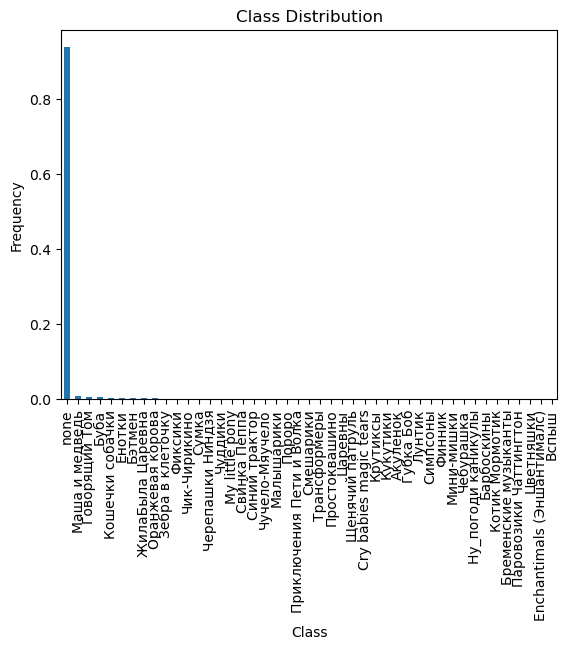

In [424]:
imba.plot_class_distribution(dtr,target_column='cartoon', rare_class_only=False, verbose=True)

Посмотрим только редкие классы

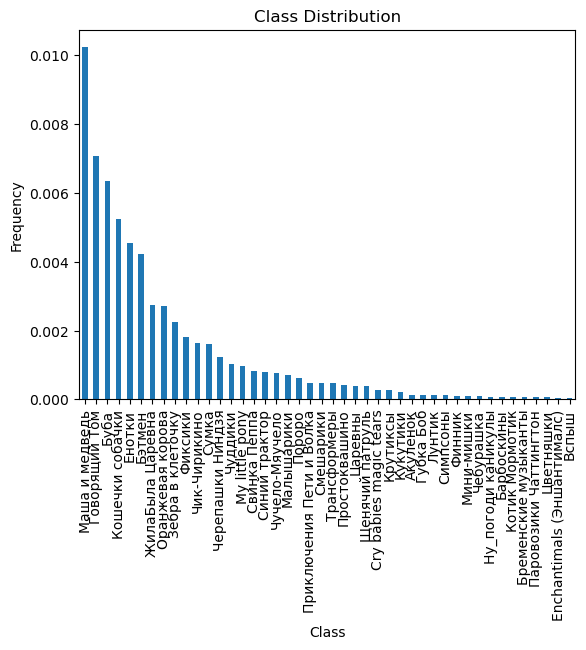

In [426]:
imba.plot_class_distribution(dtr,target_column='cartoon', rare_class_only=True, verbose=False)

В модуле imba реализованы методы балансировки с помощью SMOTE, но, поскольку будут использоваться модели со встроенными методами работы с насбалансированными классами, на данном этапе датасет не обрабатываю.

# Модели

## Distillbert

In [757]:
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer

Создадим гибридную модель (Трансформер + Dense Layers)

- Используем трансформер для обработки текстовых данных.
- Параллельно обрабатываем не текстовые данные с помощью Dense (полносвязных) слоев.
- Объединяем выходы трансформера и Dense слоев перед финальной классификацией.

In [759]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm

In [301]:
# Гибридная модель с трансформером и числовыми признаками
class HybridModel(nn.Module):
    def __init__(self, transformer_model_name, num_labels, num_numeric_features):
        super(HybridModel, self).__init__()
        
        # Модель трансформера для текстов (уменьшенная версия DistilBERT)
        self.transformer = AutoModel.from_pretrained(transformer_model_name)
        
        # Полносвязный слой для обработки текстовых данных
        self.text_fc = nn.Linear(self.transformer.config.hidden_size, 128)
        
        # Полносвязный слой для числовых данных (и других нетекстовых признаков)
        self.numeric_fc = nn.Linear(num_numeric_features, 128)
        
        # Финальный классификационный слой
        self.classifier = nn.Linear(128 * 2, num_labels)
        
    def forward(self, text_input, numeric_input):
        # Обрабатываем текстовые данные через трансформер
        transformer_output = self.transformer(**text_input)
        # Используем последнее скрытое состояние и берем среднее по всем токенам
        text_features = torch.mean(transformer_output.last_hidden_state, dim=1)
        text_features = self.text_fc(text_features)
        
        # Обрабатываем числовые данные
        numeric_features = self.numeric_fc(numeric_input)
        
        # Объединяем текстовые и числовые признаки
        combined_features = torch.cat((text_features, numeric_features), dim=1)
        
        # Применяем финальный классификационный слой
        logits = self.classifier(combined_features)
        
        return logits

In [303]:
# Выбор модели трансформера
MODEL_NAME = 'distilbert-base-multilingual-cased'  
# Другие возможные модели:
# 'distilbert-base-uncased' - еще более легкая версия модели BERT,
                            # работает быстрее, но может быть менее точной.
# 'bert-base-multilingual-cased' - более мощная версия модели, требует больше памяти.
# 'xlm-roberta-base' - мощная многоязычная модель, больше памяти и вычислительных затрат.
# Выбор модели влияет на производительность и точность:
# более легкие модели требуют меньше памяти, но могут снижать качество результатов.

# Изменяемые параметры

BATCH_SIZE = 16  # Размер батча. Возможные значения: от 8 до 64.
                 # Меньшие значения уменьшают использование памяти,
                 # но увеличивают количество шагов на эпоху.
GRADIENT_ACCUMULATION_STEPS = 4  # Количество шагов для накопления градиентов.
                 # Возможные значения: 1-8. Большее значение уменьшает
                 # нагрузку на память за счет увеличения времени обучения.
MAX_SEQ_LENGTH = 256  # Максимальная длина последовательности (в токенах).
                 # Возможные значения: от 64 до 512. Меньшие значения
                 # уменьшают использование памяти, но могут обрезать важные части текста.

LEARNING_RATE = 1e-5  # Скорость обучения. Возможные значения: 1e-6 - 1e-4.
                 # Меньшие значения могут потребовать больше эпох для обучения,
                 # но сделать обучение более стабильным.

In [307]:
num_epochs = 5
num_classes = 45

In [309]:
# Инициализируем токенизатор и модель
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [311]:
# # Функция для разделения данных на батчи с одинаковым размером для текста и числовых признаков
# def batch_loader(text_encodings, numeric_features, labels, batch_size):
#     for i in range(0, len(labels), batch_size):
#         yield {k: v[i:i + batch_size] for k, v in text_encodings.items()}, numeric_features[i:i + batch_size], labels[i:i + batch_size]

# Функция для разделения данных на батчи (для предсказания метки не нужны)
def batch_loader(text_encodings, numeric_features, labels=None, batch_size=32):
    data_size = len(numeric_features)  # используем размер числовых признаков (или текстов, они одинаковы по размеру)
    
    for i in range(0, data_size, batch_size):
        if labels is not None:
            yield {k: v[i:i + batch_size] for k, v in text_encodings.items()}, numeric_features[i:i + batch_size], labels[i:i + batch_size]
        else:
            yield {k: v[i:i + batch_size] for k, v in text_encodings.items()}, numeric_features[i:i + batch_size]

In [313]:
# Функция для токенизации и обработки признаков
def preprocess_data(df, tokenizer, max_seq_length, is_train=True, le_broadcast=None, le_channel_type=None):
    """
    Функция для токенизации текстовых данных и обработки числовых/категориальных признаков.
    
    Аргументы:
    - df: DataFrame с данными
    - tokenizer: токенайзер для текстовых данных
    - max_seq_length: максимальная длина последовательности для токенайзера
    - is_train: булево значение, указывающее, тренировочный ли это набор данных (True) или тестовый (False)
    - le_broadcast: объект LabelEncoder для поля broadcast (используется, если is_train=False)
    - le_channel_type: объект LabelEncoder для поля yt_channel_type (используется, если is_train=False)
    
    Возвращает:
    - text_encodings: токенизированные текстовые данные
    - numeric_features: тензор с числовыми признаками
    - (le_broadcast, le_channel_type): возвращает энкодеры, если is_train=True, иначе None
    """
    
    # 1. Объединение текстовых полей для токенизации
    df['combined_text'] = df['text'] + ' ' + df['reel_name']

    # 2. Токенизация текста
    text_encodings = tokenizer(
        list(df['combined_text']),
        truncation=True,
        padding=True,
        max_length=max_seq_length,
        return_tensors="pt"
    )
    
    # 3. Обработка категориальных признаков
    if is_train:
        # Для тренировочного набора данных создаем энкодеры и обучаем их
        le_broadcast = LabelEncoder()
        df['broadcast_encoded'] = le_broadcast.fit_transform(df['broadcast'])

        le_channel_type = LabelEncoder()
        df['yt_channel_type_encoded'] = le_channel_type.fit_transform(df['yt_channel_type'])
    else:
        # Для тестового набора используем уже обученные энкодеры
        df['broadcast_encoded'] = le_broadcast.transform(df['broadcast'])
        df['yt_channel_type_encoded'] = le_channel_type.transform(df['yt_channel_type'])
    
    # 4. Преобразование числовых признаков в тензор
    numeric_features = torch.tensor(
        df[['seconds', 'is_shorts', 'broadcast_encoded', 'yt_channel_type_encoded', 
            'flag_closed', 'international']].values,
        dtype=torch.float32
    )
    
    # Если это тренировочный набор данных, возвращаем также энкодеры
    if is_train:
        return text_encodings, numeric_features, le_broadcast, le_channel_type
    else:
        return text_encodings, numeric_features

In [315]:
train_text_encodings, train_numeric_features, le_broadcast, le_channel_type = preprocess_data(
    dtr, tokenizer, MAX_SEQ_LENGTH, is_train=True
)

In [259]:
# train_text_encodings.shape

In [316]:
train_numeric_features.shape

torch.Size([83411, 6])

In [317]:
# Кодирование меток

le = LabelEncoder()
y_train = le.fit_transform(dtr['cartoon'])
labels = torch.tensor(y_train, dtype=torch.long)

In [318]:
# Создаем модель
model = HybridModel(MODEL_NAME, num_labels=num_classes,
                    num_numeric_features=train_numeric_features.shape[1])
model.to(device)

# Вычисляем веса классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [319]:
# Оптимизатор
# Используемый оптимизатор. Возможные альтернативы: Adam, SGD.
# AdamW подходит для трансформеров, но может использовать больше памяти, чем SGD.
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE) 

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [269]:
# # Быстрая проверка кода на части данных
# # Используем часть данных для быстрой отладки (например, 10% от общего объема)
# sample_size = int(0.1 * len(labels))
# sample_text_encodings = {k: v[:sample_size] for k, v in text_encodings.items()}
# sample_numeric_features = numeric_features[:sample_size]
# sample_labels = labels[:sample_size]

In [271]:
# Выбираем все строки, где класс не 'none'
rare_class_mask = sample_dtr['cartoon'] != 'none'
rare_class_indices = sample_dtr[rare_class_mask].index

In [273]:
# Выбираем строки с классом 'none'
none_class_mask = sample_dtr['cartoon'] == 'none'
none_class_indices = sample_dtr[none_class_mask].index

In [275]:
# Определяем, какой процент данных класса 'none' добавить (например, 0.1 (10%))
frac = 0.1
none_sample_size = int(frac * len(none_class_indices))
none_sample_indices = np.random.choice(none_class_indices, none_sample_size, replace=False)
# none_sample_indices = none_class_indices

In [277]:
# none_sample_indices

In [279]:
# none_class_indices

In [281]:
# Объединяем индексы редких классов и часть данных класса 'none'
selected_indices = np.concatenate([rare_class_indices, none_sample_indices])


In [325]:
selected_indices = dtr.index

In [327]:
# Теперь отбираем данные по этим индексам
sample_text_encodings = {k: v[selected_indices] for k, v in train_text_encodings.items()}
sample_numeric_features = train_numeric_features[selected_indices]
sample_labels = labels[selected_indices]

In [329]:
# Изменим BATCH_SIZE для быстрой проверки
BATCH_SIZE = 4  # можно увеличить для большего объема

In [331]:
# Обучение с использованием батчей и градиентного накопления
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    
    for i, (batch_text, batch_numeric, batch_labels) \
            in enumerate(batch_loader(sample_text_encodings,
                                      sample_numeric_features,
                                      sample_labels,
                                      BATCH_SIZE)):
        batch_text = {k: v.to(device) for k, v in batch_text.items()}
        batch_numeric = batch_numeric.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        logits = model(batch_text, batch_numeric)
        loss = criterion(logits, batch_labels)
        loss = loss / GRADIENT_ACCUMULATION_STEPS  # Делим loss для накопления
        
        # Backward pass
        loss.backward()
        
        # Шаг оптимизатора на каждые GRADIENT_ACCUMULATION_STEPS
        if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}')

 20%|██        | 1/5 [1:02:30<4:10:00, 3750.21s/it]

Epoch 1/5, Loss: 579579.9195


 40%|████      | 2/5 [15:38:43<27:03:28, 32469.53s/it]

Epoch 2/5, Loss: 9637.1119


 60%|██████    | 3/5 [16:41:10<10:45:08, 19354.49s/it]

Epoch 3/5, Loss: 6274.3598


 80%|████████  | 4/5 [17:43:46<3:39:56, 13196.11s/it] 

Epoch 4/5, Loss: 4813.9842


100%|██████████| 5/5 [18:46:20<00:00, 13516.17s/it]  

Epoch 5/5, Loss: 4250.8140


In [130]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)  # Перемещаем модель на устройство

HybridModel(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

Расчет метрик. Перенесем модель и данные на ЦПУ в случае нехватки памяти на ГПУ

In [140]:
# model_cpu = model.to('cpu')

In [148]:
# sample_text_encodings = {k: v.to(device) for k, v in sample_text_encodings.items()}
# sample_numeric_features = sample_numeric_features.to(device)
# sample_labels = sample_labels.to(device)

In [150]:
# sample_text_encodings_cpu = {k: v.to('cpu') for k, v in sample_text_encodings.items()}
# sample_numeric_features_cpu = sample_numeric_features.to('cpu')
# sample_labels_cpu = sample_labels.to('cpu')  # Если метки тоже на GPU

In [144]:
# torch.cuda.empty_cache()  # Очищает кеш, но не освобождает всю память

In [154]:
# model_cpu.eval()  # Переключаем модель в режим оценки
# with torch.no_grad():  # Отключаем градиенты
#     logits = model_cpu(sample_text_encodings_cpu, sample_numeric_features_cpu)
#     predicted_probs = torch.softmax(logits, dim=1)  # Вероятности для каждого класса
#     predicted_labels = torch.argmax(predicted_probs, dim=1)  # Предсказанные метки

#     # Теперь можно рассчитать метрики, например:
#     from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#     accuracy = accuracy_score(sample_labels_cpu, predicted_labels)
#     f1 = f1_score(sample_labels_cpu, predicted_labels, average='weighted')
#     # Если у вас многоклассовая классификация, можно использовать `average='macro'` или 'weighted'
    
#     print(f'Accuracy: {accuracy}, F1: {f1}')


Accuracy: 0.9508452223953963, F1: 0.9407141884465328


Значения метрик на трэйне для базовой модели:

Accuracy: 0.9508452223953963, F1: 0.9407141884465328

Посчитаем предикты на тесте

In [198]:
# # Подготовка данных (токенизация тестовых текстов)
# test_text_encodings = tokenizer(list(dts['text']), truncation=True,
#                                 padding=True, max_length=MAX_SEQ_LENGTH,
#                                 return_tensors="pt")
# test_numeric_features = torch.tensor(
#     dts[['seconds', 'flag_closed', 'international']].values, dtype=torch.float32
# )

In [332]:
test_text_encodings, test_numeric_features = preprocess_data(
    dts, tokenizer, MAX_SEQ_LENGTH, is_train=False, le_broadcast=le_broadcast, le_channel_type=le_channel_type
)

In [333]:
print("Train numeric features shape:", train_numeric_features.shape)
print("Test numeric features shape:", test_numeric_features.shape)

Train numeric features shape: torch.Size([83411, 6])
Test numeric features shape: torch.Size([55608, 6])


In [335]:
# Переключаем модель в режим оценки
model.eval()

# Отключаем градиенты, чтобы сэкономить память
with torch.no_grad():
    all_preds = []
    
    # Прогоняем данные через модель батчами
    for batch_text, batch_numeric in batch_loader(test_text_encodings, test_numeric_features, labels=None, batch_size=BATCH_SIZE):
        batch_text = {k: v.to(device) for k, v in batch_text.items()}
        batch_numeric = batch_numeric.to(device)
        
        # Получаем предсказания
        logits = model(batch_text, batch_numeric)
        
        # Получаем предсказанные классы
        predicted_labels = torch.argmax(logits, dim=1)
        
        # Сохраняем предсказания
        all_preds.extend(predicted_labels.cpu().numpy())

In [336]:
# Преобразование предсказаний в DataFrame для сохранения в CSV
submission = pd.DataFrame({
    'yt_reel_id': dts['yt_reel_id'],  # используем уникальные идентификаторы из поля 'yt_reel_id'
    'cartoon': le.inverse_transform(all_preds)  # декодируем обратно классы из индексов
})

In [337]:
# Указываем путь к папке для сохранения
save_dir = r'C:\Users\Ivan\Documents\pro\smf\subs'
os.makedirs(save_dir, exist_ok=True)

# Путь для сохранения предиктов
subs_path = os.path.join(save_dir, 'subs_03.csv')

In [338]:
# Сохраняем предсказания в CSV для сабмита на Kaggle
submission.to_csv(subs_path, index=False)

print(f"Предсказания сохранены в файл {subs_path}")

Предсказания сохранены в файл C:\Users\Ivan\Documents\pro\smf\subs\subs_03.csv


In [346]:
submission.shape

(55608, 2)

# Model test

Используем исходные данные и закроем пропуски

In [868]:
dtr = dtr_base.copy(deep=True)

In [870]:
missval_handler = promiss.MissingValueHandler(fill_strategy = 'custom_basic', fill_values = promiss.missval_dict)

# Подгоняем обработчик на тренировочных данных
missval_handler.fit(dtr)
dtr = missval_handler.transform(dtr)

In [872]:
import hymo

In [969]:
reload(hymo)

<module 'hymo' from 'C:\\Users\\user\\Documents\\Pro\\smf\\src\\hymo.py'>

In [876]:
# Выбор модели трансформера
MODEL_NAME = 'distilbert-base-multilingual-cased'  
# Другие возможные модели:
# 'distilbert-base-uncased' - еще более легкая версия модели BERT,
                            # работает быстрее, но может быть менее точной.
# 'bert-base-multilingual-cased' - более мощная версия модели, требует больше памяти.
# 'xlm-roberta-base' - мощная многоязычная модель, больше памяти и вычислительных затрат.
# Выбор модели влияет на производительность и точность:
# более легкие модели требуют меньше памяти, но могут снижать качество результатов.

# Изменяемые параметры

BATCH_SIZE = 16  # Размер батча. Возможные значения: от 8 до 64.
                 # Меньшие значения уменьшают использование памяти,
                 # но увеличивают количество шагов на эпоху.
GRADIENT_ACCUMULATION_STEPS = 4  # Количество шагов для накопления градиентов.
                 # Возможные значения: 1-8. Большее значение уменьшает
                 # нагрузку на память за счет увеличения времени обучения.
MAX_SEQ_LENGTH = 256  # Максимальная длина последовательности (в токенах).
                 # Возможные значения: от 64 до 512. Меньшие значения
                 # уменьшают использование памяти, но могут обрезать важные части текста.

LEARNING_RATE = 1e-5  # Скорость обучения. Возможные значения: 1e-6 - 1e-4.
                 # Меньшие значения могут потребовать больше эпох для обучения,
                 # но сделать обучение более стабильным.

In [878]:
num_epochs = 5
num_classes = 45

In [880]:
target = 'cartoon'

In [971]:
# Создадим обработчик данных
processor = hymo.DataPreprocessor(transformer_model_name=MODEL_NAME,max_seq_length=MAX_SEQ_LENGTH)

In [973]:
# Создадим сниппет данных для теста
sample_dtr = processor.get_data(df=dtr,use_snippet=True,
                                fields=['is_shorts', 'broadcast',
                                        'yt_channel_type', 'flag_closed', 'international'],
                                none_obj_count=2,
                                rare_obj_count=2)

In [975]:
sample_dtr.shape

(112, 16)

In [987]:
sample_dtr.index

Index([ 9852, 22997, 46859, 65629,  1407,  4780, 33801, 72846, 83022, 65565,
       ...
       48252,  2860, 81458, 54593, 49649, 31319, 12361, 10003, 11164, 12220],
      dtype='int64', length=112)

In [977]:
# Создадим модель
hymodel = hymo.HybridModel(transformer_model_name=MODEL_NAME,num_labels=num_classes)

In [979]:
# Создадим необходимые объекты для модели
hyserv = hymo.ModelService(model=hymodel,transformer_model_name=MODEL_NAME,
                           df=sample_dtr,target=target,
                            optimizer_type='adam',learning_rate=LEARNING_RATE)

In [981]:
 hyserv.encoded_labels

tensor([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  0,  0,  1,  1,  2,  2,  4,  4,  5,  5,  6,  6,
         7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15,
        16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24,
        25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33,
        34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42,
        43, 43, 44, 44])

In [983]:
# Подготовим данные
text_encodings, numeric_features, le_broadcast, le_channel_type =\
processor.preprocess_data(sample_dtr,is_train=True)

In [965]:
# text_encodings

In [985]:
sample_text_encodings, sample_numeric_features, sample_labels = \
processor.prepare_data_for_training(sample_dtr,text_encodings, numeric_features,
                                    hyserv.encoded_labels)

112


IndexError: index 9852 is out of bounds for dimension 0 with size 112

In [350]:
# Сохранение весов модели
torch.save(model.state_dict(), weights_path)
print(f'Веса модели сохранены по пути: {weights_path}')

Веса модели сохранены по пути: C:\Users\Ivan\Documents\pro\smf\models\base_model_weights_02.pth


In [352]:
# Сохранение всей модели
torch.save(model, model_path)
print(f'Вся модель сохранена по пути: {model_path}')

Вся модель сохранена по пути: C:\Users\Ivan\Documents\pro\smf\models\base_model_02.pth


In [163]:
base_model_cpu = torch.load(model_path)
base_model_cpu.eval()  # Переводим модель в режим оценки

C:\Users\Ivan\AppData\Local\Temp\ipykernel_8308\1233064284.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model_cpu = torch.load(model_path)


HybridModel(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin